In [7]:
from pathlib import Path
import re
import pandas as pd

# === 配置路径 | Paths ===
input_dir = Path("Data")                 # 你的 Excel 文件目录
output_path = input_dir / "fintech_indices_merged.xlsx"  # 合并后输出

# === 工具函数：清洗并去重 sheet 名 | Sheet-name sanitizer ===
def sanitize_sheet_name(name: str) -> str:
    # Excel 不允许的字符： : \ / ? * [ ]
    name = re.sub(r'[:\\/?*\[\]]', '-', name)
    name = name.strip()
    # 处理空字符串情况
    if not name:
        name = "Unnamed"
    return name[:31] if len(name) > 31 else name

excel_files = sorted([p for p in input_dir.glob("*.xls*")
                      if p.suffix.lower() in {".xlsx", ".xlsm", ".xls"}])
if not excel_files:
    raise FileNotFoundError(f"No Excel files found in: {input_dir.resolve()}")

used_sheet_names = set()
all_names = []

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for fpath in excel_files:
        try:
            xfile = pd.ExcelFile(fpath)
        except Exception as e:
            print(f"⚠️  Warning: Could not read {fpath.name}: {e}")
            continue

        for sname in xfile.sheet_names:
            try:
                df = xfile.parse(sname)

                # 跳过空表
                if df.empty:
                    print(f"⚠️  Warning: Sheet '{sname}' in {fpath.name} is empty, skipping")
                    continue

                base = f"{fpath.stem}-{sname}"
                sheet_name = sanitize_sheet_name(base)
                original_sheet_name = sheet_name
                if sheet_name in used_sheet_names:
                    i = 1
                    while True:
                        candidate = sanitize_sheet_name(f"{original_sheet_name}-{i}")
                        if candidate not in used_sheet_names:
                            sheet_name = candidate
                            break
                        i += 1
                        if i > 100:  # 安全限制
                            sheet_name = sanitize_sheet_name(f"{original_sheet_name}-dup")
                            break

                df.to_excel(writer, sheet_name=sheet_name, index=False)
                used_sheet_names.add(sheet_name)

                # --- 从该表抽取 Name 列，加入统计池 | collect 'Name' for summary
                # 容错匹配（大小写/空格） | tolerant match
                cols_norm = {c: str(c).strip().lower() for c in df.columns}
                name_col = next((orig for orig, low in cols_norm.items()
                               if low in ["name", "名称", "姓名"]), None)

                if name_col is not None:
                    names = (df[name_col]
                             .dropna()
                             .astype(str)
                             .str.strip()
                             .replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
                             .dropna())
                    # 统一大小写避免同名大小写差异 | normalize case to merge duplicates
                    if not names.empty:
                        names = names.str.upper()
                        all_names.append(names)

            except Exception as e:
                print(f"⚠️  Warning: Could not process sheet '{sname}' in {fpath.name}: {e}")
                continue

    # === 生成 Summary 子表 | Build and write Summary sheet ===
    if all_names:
        try:
            all_names_series = pd.concat(all_names, ignore_index=True)
            # 过滤掉明显不是人名的条目（如数字、过短字符串）
            valid_names = all_names_series[all_names_series.str.len() >= 2]  # 至少2个字符
            if not valid_names.empty:
                summary = (valid_names.value_counts()
                           .rename_axis("Name")
                           .reset_index(name="Count")
                           .sort_values(["Count", "Name"], ascending=[False, True]))
                summary.to_excel(writer, sheet_name="Summary", index=False)
            else:
                print("⚠️  Warning: No valid names found for Summary sheet")
        except Exception as e:
            print(f"⚠️  Warning: Could not create Summary sheet: {e}")
    else:
        print("⚠️  Warning: No name data found for Summary sheet")

print(f"✅ Done. Merged {len(used_sheet_names)} sheets -> {output_path}")
if all_names:
    all_names_series = pd.concat(all_names, ignore_index=True)
    print(f"📊 Summary: {len(all_names_series)} total name entries")

⚠️  Warning: Could not read fintech_indices_merged.xlsx: Excel file format cannot be determined, you must specify an engine manually.
✅ Done. Merged 7 sheets -> Data/fintech_indices_merged.xlsx
📊 Summary: 390 total name entries


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np

stock_mapping = [
    ("Cryptocurrency", "COINBASE GLOBAL INC -CLASS A", "COIN"),
    ("Cryptocurrency", "BLOCK INC", "XYZ"),
    ("Cryptocurrency", "RIOT PLATFORMS INC", "RIOT"),
    ("Cryptocurrency", "CIPHER MINING INC", "CIFR"),
    ("Cryptocurrency", "MARATHON HOLDINGS INC", "MARA"),
    ("Credit Card & BNPL", "AFFIRM HOLDINGS INC", "AFRM"),
    ("Credit Card & BNPL", "AFTERPAY", "APTY"),
    ("Credit Card & BNPL", "MARQETA INC-A", "MQ"),
    ("Credit Card & BNPL", "BREAD FINANCIAL HOLDINGS INC", "BFH"),
    ("Credit Card & BNPL", "SEZZLE INC", "SEZL"),
    ("Fintech Hardware", "TOAST INC-CLASS A", "TOST"),
    ("Fintech Hardware", "SHIFT4 PAYMENTS INC", "FOUR"),
    ("Fintech Hardware", "VERIFONE", "VERI"),
    ("Fintech Hardware", "PAX GLOBAL TECHNOLOGY LTD", "PAX"),
    ("Data Processing & Outsourced Services", "INTUIT INC", "INTU"),
    ("Data Processing & Outsourced Services", "SS&C TECHNOLOGIES HOLDINGS", "SSNC"),
    ("Data Processing & Outsourced Services", "BLACKLINE INC", "BL"),
    ("Data Processing & Outsourced Services", "FIDELITY NATIONAL INFO SERV (FIS)", "FIS"),
    ("Data Processing & Outsourced Services", "FISERV INC", "FI"),
]
map_df = pd.DataFrame(stock_mapping, columns=["Sub Theme", "Company", "Ticker"])

tickers = map_df["Ticker"].unique().tolist()
# chunks = [tickers[i:i+2] for i in range(0, len(tickers), 2)]
data_list = []
for ticker in tickers:
    data = yf.download(ticker, start="2023-01-01", end="2025-10-01", interval="1d", auto_adjust=False, threads=False)
    data_list.append(data)
prices = pd.concat(data_list, axis=1)


df = prices.stack(level=0).reset_index()
df = df.rename(columns={"level_0": "Date", "level_1": "Ticker"})
df = df.merge(map_df, on="Ticker", how="left")
df = df.sort_values(["Ticker", "Date"])
df["r_t"] = df.groupby("Ticker")["Adj Close"].transform(lambda s: np.log(s / s.shift(1)))
df = df.dropna(subset=["r_t"])


cols_front = ["Date", "Sub Theme", "Company", "Ticker", "Open", "High", "Low", "Close", "Adj Close", "Volume", "r_t"]
df = df[[c for c in cols_front if c in df.columns]]
df.to_csv('test.csv', index=False)
print(df.head(12))

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XYZ']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIOT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CIFR']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MARA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AFRM']: YFRateLimitError('Too Many Requests. Rate limit

KeyError: 'Ticker'

In [7]:
import time
import yfinance as yf
import pandas as pd
import numpy as np

# 你的映射表 map_df 保持不變
stock_mapping = [
    ("Cryptocurrency", "COINBASE GLOBAL INC -CLASS A", "COIN"),
    ("Cryptocurrency", "BLOCK INC", "XYZ"),
    ("Cryptocurrency", "RIOT PLATFORMS INC", "RIOT"),
    ("Cryptocurrency", "CIPHER MINING INC", "CIFR"),
    ("Cryptocurrency", "MARATHON HOLDINGS INC", "MARA"),
    ("Credit Card & BNPL", "AFFIRM HOLDINGS INC", "AFRM"),
    ("Credit Card & BNPL", "AFTERPAY", "APTY"),
    ("Credit Card & BNPL", "MARQETA INC-A", "MQ"),
    ("Credit Card & BNPL", "BREAD FINANCIAL HOLDINGS INC", "BFH"),
    ("Credit Card & BNPL", "SEZZLE INC", "SEZL"),
    ("Fintech Hardware", "TOAST INC-CLASS A", "TOST"),
    ("Fintech Hardware", "SHIFT4 PAYMENTS INC", "FOUR"),
    ("Fintech Hardware", "VERIFONE", "VERI"),
    ("Fintech Hardware", "PAX GLOBAL TECHNOLOGY LTD", "PAX"),
    ("Data Processing & Outsourced Services", "INTUIT INC", "INTU"),
    ("Data Processing & Outsourced Services", "SS&C TECHNOLOGIES HOLDINGS", "SSNC"),
    ("Data Processing & Outsourced Services", "BLACKLINE INC", "BL"),
    ("Data Processing & Outsourced Services", "FIDELITY NATIONAL INFO SERV (FIS)", "FIS"),
    ("Data Processing & Outsourced Services", "FISERV INC", "FI"),
]
map_df = pd.DataFrame(stock_mapping, columns=["Sub Theme", "Company", "Ticker"])



def download_prices_chunked(tickers, start, end, interval="1d", pause=1.2):
    rows = []
    ok, bad = [], []
    for t in tickers:
        try:
            df = yf.download(
                t, start=start, end=end, interval=interval,
                auto_adjust=False, progress=False, threads=False
            )
            if df.empty:
                bad.append((t, "empty"))
            else:
                df = df.reset_index().rename(columns={"Adj Close": "AdjClose"})
                df["Ticker"] = t
                rows.append(df[["Date","Ticker","Open","High","Low","Close","AdjClose","Volume"]])
                ok.append(t)
        except Exception as e:
            bad.append((t, str(e)))
        time.sleep(pause)  # 限流友好 / be nice to rate limits
    if rows:
        out = pd.concat(rows, ignore_index=True)
    else:
        out = pd.DataFrame(columns=["Date","Ticker","Open","High","Low","Close","AdjClose","Volume"])
    return out, ok, bad

tickers = map_df["Ticker"].unique().tolist()
prices_long, ok, bad = download_prices_chunked(
    tickers, start="2020-01-01", end="2025-10-01", interval="1d", pause=1.2
)

print("Succeeded:", ok)
print("Failed:", bad)

# 合併映射 / merge mapping
df = prices_long.merge(map_df, on="Ticker", how="left")

# 計算對數收益 / log returns
df = df.sort_values(["Ticker","Date"])
df["r_t"] = df.groupby("Ticker")["AdjClose"].transform(lambda s: np.log(s / s.shift(1)))
# 如果你想避免第一行 NaN：填 0
# df["r_t"] = df["r_t"].fillna(0)

# 整理列順序 / reorder
cols = ["Date","Sub Theme","Company","Ticker","Open","High","Low","Close","AdjClose","Volume","r_t"]
df = df[[c for c in cols if c in df.columns]]

df.to_csv("fintech_prices.csv", index=False)
print(df.head())



1 Failed download:
['COIN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['XYZ']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['RIOT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['CIFR']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['MARA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['AFRM']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['APTY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['MQ']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['BFH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['SEZL']: YFRateLimitError('Too Many Requests. Rate limited. Try a

Succeeded: []
Failed: [('COIN', 'empty'), ('XYZ', 'empty'), ('RIOT', 'empty'), ('CIFR', 'empty'), ('MARA', 'empty'), ('AFRM', 'empty'), ('APTY', 'empty'), ('MQ', 'empty'), ('BFH', 'empty'), ('SEZL', 'empty'), ('TOST', 'empty'), ('FOUR', 'empty'), ('VERI', 'empty'), ('PAX', 'empty'), ('INTU', 'empty'), ('SSNC', 'empty'), ('BL', 'empty'), ('FIS', 'empty'), ('FI', 'empty')]
Empty DataFrame
Columns: [Date, Sub Theme, Company, Ticker, Open, High, Low, Close, AdjClose, Volume, r_t]
Index: []


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# ---- 1) 映射表 / Mapping table ----
rows = [
    # SubTheme, Company, Ticker
    ("Cryptocurrency", "COINBASE GLOBAL INC -CLASS A", "COIN"),
    ("Cryptocurrency", "BLOCK INC", "XYZ"),   # 用你表里的ticker；若实际下载失败，可把它改成 SQ
    ("Cryptocurrency", "RIOT PLATFORMS INC", "RIOT"),
    ("Cryptocurrency", "CIPHER MINING INC", "CIFR"),
    ("Cryptocurrency", "MARATHON HOLDINGS INC", "MARA"),
    ("Credit Card & BNPL", "AFFIRM HOLDINGS INC", "AFRM"),
    ("Credit Card & BNPL", "AFTERPAY", "APTY"),
    ("Credit Card & BNPL", "MARQETA INC-A", "MQ"),
    ("Credit Card & BNPL", "BREAD FINANCIAL HOLDINGS INC", "BFH"),
    ("Credit Card & BNPL", "SEZZLE INC", "SEZL"),
    ("Fintech Hardware", "TOAST INC-CLASS A", "TOST"),
    ("Fintech Hardware", "SHIFT4 PAYMENTS INC", "FOUR"),
    ("Fintech Hardware", "VERIFONE", "VERI"),
    ("Fintech Hardware", "PAX GLOBAL TECHNOLOGY LTD", "PAX"),
    ("Data Processing & Outsourced Services", "INTUIT INC", "INTU"),
    ("Data Processing & Outsourced Services", "SS&C TECHNOLOGIES HOLDINGS", "SSNC"),
    ("Data Processing & Outsourced Services", "BLACKLINE INC", "BL"),
    ("Data Processing & Outsourced Services", "FIDELITY NATIONAL INFO SERV (FIS)", "FIS"),
    ("Data Processing & Outsourced Services", "FISERV INC", "FI"),
]

map_df = pd.DataFrame(rows, columns=["Sub Theme", "Company", "Ticker"])

print(f"将下载 {len(map_df)} 只股票的数据")

# ---- 2) 下载价格 / Download prices ----
tickers = map_df["Ticker"].unique().tolist()

try:
    prices = yf.download(
        tickers, start="2020-01-01", end="2025-10-01",
        interval="1d", group_by="ticker", auto_adjust=True, threads=True
    )

    # 检查下载结果
    if prices.empty:
        raise ValueError("没有下载到任何数据")

    # 处理单只股票的情况
    if len(tickers) == 1 and not isinstance(prices.columns, pd.MultiIndex):
        prices = pd.DataFrame(prices)
        prices.columns = pd.MultiIndex.from_product([prices.columns, [tickers[0]]])

except Exception as e:
    print(f"下载价格数据时出错: {e}")
    exit()

# ---- 3) 转换数据格式 / Transform to long format ----
df = prices.stack(level=0).reset_index()
df = df.rename(columns={"level_0": "Date", "level_1": "Ticker"})

# ---- 4) 合并映射 / Merge mapping ----
df = df.merge(map_df, on="Ticker", how="left")

# ---- 5) 计算基础指标 / Compute basic metrics ----
df = df.sort_values(["Ticker", "Date"])

# 确保列名正确
if 'Adj Close' in df.columns:
    price_col = 'Adj Close'
elif 'Close' in df.columns:
    price_col = 'Close'
    df['Adj Close'] = df['Close']  # 如果没有调整后收盘价，使用收盘价
else:
    raise ValueError("没有找到价格列")

# 计算对数收益率
df["r_t"] = df.groupby("Ticker")[price_col].transform(lambda s: np.log(s / s.shift(1)))

# ---- 6) 技术指标计算函数 / Technical indicator functions ----
def calculate_technical_indicators(df_group):
    """为单个股票计算技术指标"""
    group = df_group.copy().sort_values('Date')

    # 使用调整后收盘价或收盘价
    close = group[price_col].values

    # === 移动平均线 ===
    group['MA_5'] = group[price_col].rolling(window=5).mean()
    group['MA_20'] = group[price_col].rolling(window=20).mean()
    group['MA_50'] = group[price_col].rolling(window=50).mean()
    group['MA_200'] = group[price_col].rolling(window=200).mean()

    # === 指数移动平均线 ===
    group['EMA_12'] = group[price_col].ewm(span=12).mean()
    group['EMA_26'] = group[price_col].ewm(span=26).mean()

    # === MACD ===
    group['MACD'] = group['EMA_12'] - group['EMA_26']
    group['MACD_Signal'] = group['MACD'].ewm(span=9).mean()
    group['MACD_Histogram'] = group['MACD'] - group['MACD_Signal']

    # === RSI ===
    def compute_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    group['RSI_14'] = compute_rsi(group[price_col])

    # === 布林带 ===
    rolling_mean = group[price_col].rolling(window=20).mean()
    rolling_std = group[price_col].rolling(window=20).std()
    group['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    group['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)
    group['Bollinger_Middle'] = rolling_mean
    group['Bollinger_Width'] = (group['Bollinger_Upper'] - group['Bollinger_Lower']) / group['Bollinger_Middle']

    # === 波动率指标 ===
    group['Volatility_20d'] = group['r_t'].rolling(window=20).std() * np.sqrt(252)  # 年化波动率
    group['Volatility_60d'] = group['r_t'].rolling(window=60).std() * np.sqrt(252)

    # 真实波动幅度 (ATR)
    high_low = group['High'] - group['Low']
    high_close = np.abs(group['High'] - group[price_col].shift())
    low_close = np.abs(group['Low'] - group[price_col].shift())
    true_range = np.maximum(np.maximum(high_low, high_close), low_close)
    group['ATR_14'] = true_range.rolling(window=14).mean()

    # === 动量指标 ===
    group['Momentum_1M'] = group[price_col] / group[price_col].shift(21) - 1  # 1个月动量
    group['Momentum_3M'] = group[price_col] / group[price_col].shift(63) - 1  # 3个月动量
    group['Momentum_6M'] = group[price_col] / group[price_col].shift(126) - 1  # 6个月动量

    # === 支撑阻力 ===
    group['Support_Resistance_Ratio'] = (group[price_col] - group['Bollinger_Lower']) / (group['Bollinger_Upper'] - group['Bollinger_Lower'])

    # === 价格位置 ===
    rolling_min = group[price_col].rolling(window=20).min()
    rolling_max = group[price_col].rolling(window=20).max()
    group['Price_Position_20d'] = (group[price_col] - rolling_min) / (rolling_max - rolling_min)

    return group

# ---- 7) 应用技术指标计算 / Apply technical indicators ----
print("计算技术指标...")
df_with_indicators = df.groupby('Ticker').apply(calculate_technical_indicators).reset_index(drop=True)

# ---- 8) 创建分析指标汇总DataFrame / Create analysis summary DataFrame ----
def create_analysis_summary(df_with_indicators):
    """创建每个股票的指标汇总表"""
    summary_data = []

    for ticker in df_with_indicators['Ticker'].unique():
        ticker_data = df_with_indicators[df_with_indicators['Ticker'] == ticker].copy()

        if ticker_data.empty:
            continue

        # 获取最新数据
        latest = ticker_data.iloc[-1]

        # 获取子主题和公司名称
        sub_theme = latest['Sub Theme']
        company = latest['Company']

        # 基础价格信息
        current_price = latest[price_col]
        price_1d_change = ticker_data['r_t'].iloc[-1] if not pd.isna(ticker_data['r_t'].iloc[-1]) else 0

        # 计算各种时间周期的收益率
        periods = {
            '1W': 5, '1M': 21, '3M': 63, '6M': 126, '1Y': 252, 'YTD': 'ytd'
        }

        returns = {}
        for period_name, period_days in periods.items():
            if period_days == 'ytd':
                # 年初至今收益
                ytd_data = ticker_data[ticker_data['Date'] >= f"{datetime.now().year}-01-01"]
                if len(ytd_data) > 1:
                    returns[period_name] = (ytd_data[price_col].iloc[-1] / ytd_data[price_col].iloc[0] - 1) * 100
                else:
                    returns[period_name] = 0
            else:
                if len(ticker_data) > period_days:
                    returns[period_name] = (ticker_data[price_col].iloc[-1] / ticker_data[price_col].iloc[-period_days-1] - 1) * 100
                else:
                    returns[period_name] = 0

        # 技术指标状态
        ma_trend = "上涨" if latest['MA_20'] > latest['MA_50'] else "下跌" if latest['MA_20'] < latest['MA_50'] else "盘整"

        rsi_status = "超买" if latest.get('RSI_14', 50) > 70 else "超卖" if latest.get('RSI_14', 50) < 30 else "中性"

        macd_signal = "买入" if latest.get('MACD_Histogram', 0) > 0 else "卖出" if latest.get('MACD_Histogram', 0) < 0 else "中性"

        volatility_level = "高" if latest.get('Volatility_20d', 0) > 0.4 else "低" if latest.get('Volatility_20d', 0) < 0.2 else "中"

        # 支撑阻力状态
        if latest.get('Support_Resistance_Ratio', 0.5) > 0.7:
            sr_status = "接近阻力"
        elif latest.get('Support_Resistance_Ratio', 0.5) < 0.3:
            sr_status = "接近支撑"
        else:
            sr_status = "中间区域"

        summary_data.append({
            'Ticker': ticker,
            'Company': company,
            'Sub Theme': sub_theme,
            'Current Price': current_price,
            '1D Return (%)': price_1d_change * 100,
            **returns,
            'MA Trend': ma_trend,
            'RSI Status': rsi_status,
            'MACD Signal': macd_signal,
            'Volatility Level': volatility_level,
            'Support Resistance': sr_status,
            '20D Volatility': latest.get('Volatility_20d', 0),
            'RSI': latest.get('RSI_14', 50),
            'Volume (1M avg)': ticker_data['Volume'].tail(21).mean(),
            'Last Updated': latest['Date']
        })

    return pd.DataFrame(summary_data)

# ---- 9) 生成分析汇总表 / Generate analysis summary ----
print("生成分析汇总表...")
analysis_summary = create_analysis_summary(df_with_indicators)

# ---- 10) 数据输出 / Data output ----
# 原始数据（包含技术指标）
output_cols = ["Date", "Sub Theme", "Company", "Ticker", "Open", "High", "Low", "Close",
               "Adj Close", "Volume", "r_t", "MA_5", "MA_20", "MA_50", "MA_200",
               "RSI_14", "MACD", "MACD_Signal", "MACD_Histogram", "Volatility_20d"]

# 只选择存在的列
available_cols = [col for col in output_cols if col in df_with_indicators.columns]
df_final = df_with_indicators[available_cols]

# 保存数据
df_final.to_csv('stock_data_with_indicators.csv', index=False)
analysis_summary.to_csv('stock_analysis_summary.csv', index=False)

print(f"\n=== 数据生成完成 ===")
print(f"原始数据（含技术指标）: {len(df_final)} 行，保存至 stock_data_with_indicators.csv")
print(f"分析汇总表: {len(analysis_summary)} 只股票，保存至 stock_analysis_summary.csv")

print(f"\n=== 分析汇总表前10行 ===")
print(analysis_summary.head(10))

print(f"\n=== 关键指标统计 ===")
print(f"平均20日波动率: {analysis_summary['20D Volatility'].mean():.2%}")
print(f"RSI中性比例: {(analysis_summary['RSI'].between(30, 70)).mean():.1%}")
print(f"上涨趋势股票: {(analysis_summary['MA Trend'] == '上涨').mean():.1%}")

# ---- 11) 额外分析：按子主题分组统计 ----
if 'Sub Theme' in analysis_summary.columns:
    print(f"\n=== 按子主题分析 ===")
    theme_analysis = analysis_summary.groupby('Sub Theme').agg({
        '1D Return (%)': 'mean',
        '1M Return (%)': 'mean',
        '20D Volatility': 'mean',
        'RSI': 'mean',
        'Ticker': 'count'
    }).round(3)

    theme_analysis = theme_analysis.rename(columns={'Ticker': 'Stock Count'})
    print(theme_analysis)

In [6]:
import yfinance as yf

ticker_list = ["AAPL","MSFT"]

for t in ticker_list:
    tk = yf.Ticker(t)

    # 基本财务报表 / Financial Statements
    print(f"=== {t} Balance Sheet ===")
    print(tk.balance_sheet.head())

    print(f"=== {t} Income Statement ===")
    print(tk.financials.head())

    print(f"=== {t} Cash Flow ===")
    print(tk.cashflow.head())

    # 公司概况 / Company Info
    print(tk.info)  # dict，包括市值、市盈率、行业、Beta 等

    # 分析师指标 / Analysts
    print(tk.analyst_price_targets)
    print(tk.recommendations.tail())


=== AAPL Balance Sheet ===
                          2024-09-30    2023-09-30    2022-09-30    2021-09-30
Treasury Shares Number           NaN  0.000000e+00           NaN           NaN
Ordinary Shares Number  1.511679e+10  1.555006e+10  1.594342e+10  1.642679e+10
Share Issued            1.511679e+10  1.555006e+10  1.594342e+10  1.642679e+10
Net Debt                7.668600e+10  8.112300e+10  9.642300e+10  8.977900e+10
Total Debt              1.066290e+11  1.110880e+11  1.324800e+11  1.365220e+11
=== AAPL Income Statement ===
                                                      2024-09-30  \
Tax Effect Of Unusual Items                         0.000000e+00   
Tax Rate For Calcs                                  2.410000e-01   
Normalized EBITDA                                   1.346610e+11   
Net Income From Continuing Operation Net Minori...  9.373600e+10   
Reconciled Depreciation                             1.144500e+10   

                                                      2023-0

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Enhanced stock data downloader with price + fundamentals from yfinance.
Outputs tidy long tables for easy aggregation with improved reliability.
"""

import os
import time
import logging
from typing import List, Dict, Optional, Union
import pandas as pd
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import warnings

# Suppress yfinance warnings
warnings.filterwarnings("ignore")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class DownloadConfig:
    """Configuration for data download parameters."""
    start: str = "2000-01-01"
    end: Optional[str] = None
    interval: str = "1d"
    out_dir: str = "./out"
    max_workers: int = 4
    request_delay: float = 0.3
    auto_adjust: bool = False
    timeout: int = 30
    max_retries: int = 2

class StockDataDownloader:
    """Main class for downloading and processing stock data."""

    def __init__(self, config: DownloadConfig):
        self.config = config
        os.makedirs(config.out_dir, exist_ok=True)

    def to_long_prices(self, df_multi: pd.DataFrame) -> pd.DataFrame:
        """Convert yf.download wide MultiIndex columns to tidy long format."""
        if df_multi.empty:
            return pd.DataFrame(columns=["date", "ticker", "open", "high", "low", "close", "adj_close", "volume"])

        # Handle single ticker case (no MultiIndex)
        if not isinstance(df_multi.columns, pd.MultiIndex):
            df_long = df_multi.reset_index()
            df_long["ticker"] = "SINGLE"  # Placeholder, will be updated later
            # Standardize column names
            df_long = df_long.rename(columns={
                "Date": "date", "Open": "open", "High": "high", "Low": "low",
                "Close": "close", "Adj Close": "adj_close", "Volume": "volume"
            })
        else:
            # Multiple tickers case
            df_long = df_multi.stack(level=0).reset_index()
            df_long = df_long.rename(columns={
                "level_0": "date", "level_1": "ticker"
            })
            # Standardize column names
            rename_map = {
                "Open": "open", "High": "high", "Low": "low", "Close": "close",
                "Adj Close": "adj_close", "Volume": "volume"
            }
            df_long = df_long.rename(columns=rename_map)

        # Ensure consistent column order and types
        expected_cols = ["date", "ticker", "open", "high", "low", "close", "adj_close", "volume"]
        for col in expected_cols:
            if col not in df_long.columns:
                df_long[col] = None

        df_long = df_long[expected_cols]
        df_long["date"] = pd.to_datetime(df_long["date"])

        return df_long

    def safe_get(self, data, key, default=None, data_type=None):
        """Safely get value from dictionary or object with type conversion."""
        try:
            if isinstance(data, dict):
                value = data.get(key, default)
            else:
                value = getattr(data, key, default)

            # Type conversion
            if data_type and value is not None:
                try:
                    if data_type == "float":
                        value = float(value)
                    elif data_type == "int":
                        value = int(value)
                    elif data_type == "str":
                        value = str(value)
                except (ValueError, TypeError):
                    value = default

            return value
        except Exception:
            return default

    def flatten_info(self, ticker_obj: yf.Ticker) -> dict:
        """Collect comprehensive snapshot from info and fast_info."""
        out = {"ticker": ticker_obj.ticker}

        # Get info with error handling
        try:
            info = ticker_obj.info or {}
        except Exception as e:
            logger.warning(f"Failed to get info for {ticker_obj.ticker}: {e}")
            info = {}

        # Get fast_info with error handling
        try:
            fast_info = ticker_obj.fast_info or {}
        except Exception as e:
            logger.debug(f"Failed to get fast_info for {ticker_obj.ticker}: {e}")
            fast_info = {}

        # Define fields to extract with their types
        info_fields = {
            # Basic identity
            "shortName": ("str", None),
            "longName": ("str", None),
            "country": ("str", None),
            "sector": ("str", None),
            "industry": ("str", None),
            "currency": ("str", None),
            "exchange": ("str", None),
            "quoteType": ("str", None),

            # Valuation
            "marketCap": ("float", None),
            "trailingPE": ("float", None),
            "forwardPE": ("float", None),
            "priceToBook": ("float", None),
            "enterpriseValue": ("float", None),
            "enterpriseToRevenue": ("float", None),
            "enterpriseToEbitda": ("float", None),
            "beta": ("float", None),
            "pegRatio": ("float", None),

            # Margins
            "profitMargins": ("float", None),
            "grossMargins": ("float", None),
            "operatingMargins": ("float", None),
            "ebitdaMargins": ("float", None),

            # Per-share metrics
            "trailingEps": ("float", None),
            "forwardEps": ("float", None),
            "bookValue": ("float", None),
            "revenuePerShare": ("float", None),

            # Growth
            "earningsQuarterlyGrowth": ("float", None),
            "revenueGrowth": ("float", None),

            # Financials
            "totalCash": ("float", None),
            "totalDebt": ("float", None),
            "totalRevenue": ("float", None),
            "ebitda": ("float", None),
            "freeCashflow": ("float", None),
            "operatingCashflow": ("float", None),

            # Ratios
            "debtToEquity": ("float", None),
            "currentRatio": ("float", None),
            "quickRatio": ("float", None),

            # Dividends
            "dividendRate": ("float", None),
            "dividendYield": ("float", None),
            "payoutRatio": ("float", None),
        }

        # Extract info fields
        for field, (data_type, default) in info_fields.items():
            out[field] = self.safe_get(info, field, default, data_type)

        # Extract fast_info fields
        fast_info_fields = [
            "lastPrice", "dayHigh", "dayLow", "yearHigh", "yearLow",
            "previousClose", "open", "marketCap", "shares",
            "volume", "averageVolume10Day", "averageVolume3Month"
        ]

        for field in fast_info_fields:
            out[f"fast_{field}"] = self.safe_get(fast_info, field, None, "float")

        # Name fallback - ensure longName always exists
        if not out.get("longName"):
            out["longName"] = out.get("shortName") or out["ticker"]

        # Add timestamp
        out["snapshot_timestamp"] = pd.Timestamp.now()

        return out

    def melt_statements(self, df: pd.DataFrame, ticker: str, period: str, statement: str) -> pd.DataFrame:
        """Convert wide financial statements to long format."""
        if df is None or df.empty:
            return pd.DataFrame(columns=["ticker", "as_of_date", "period", "statement", "item", "value"])

        try:
            df = df.copy()
            # Convert column names to datetime
            df.columns = pd.to_datetime(df.columns, errors="coerce")

            # Reset index and melt
            df = df.reset_index().rename(columns={"index": "item"})
            df = df.melt(
                id_vars=["item"],
                var_name="as_of_date",
                value_name="value"
            )

            # Add metadata
            df["ticker"] = ticker
            df["period"] = period
            df["statement"] = statement

            # Filter and sort
            df = df.dropna(subset=["as_of_date", "item"])
            df = df[["ticker", "as_of_date", "period", "statement", "item", "value"]]
            df = df.sort_values(["ticker", "as_of_date", "statement", "item"])

            return df

        except Exception as e:
            logger.warning(f"Error melting statements for {ticker}: {e}")
            return pd.DataFrame(columns=["ticker", "as_of_date", "period", "statement", "item", "value"])

    def safe_download_data(self, ticker_obj, data_type, retries=2):
        """Safely download data with retry logic."""
        for attempt in range(retries + 1):
            try:
                if data_type == "financials":
                    result = ticker_obj.financials
                elif data_type == "balance_sheet":
                    result = ticker_obj.balance_sheet
                elif data_type == "cashflow":
                    result = ticker_obj.cashflow
                elif data_type == "quarterly_financials":
                    result = ticker_obj.quarterly_financials
                elif data_type == "quarterly_balance_sheet":
                    result = ticker_obj.quarterly_balance_sheet
                elif data_type == "quarterly_cashflow":
                    result = ticker_obj.quarterly_cashflow
                elif data_type == "dividends":
                    result = ticker_obj.dividends
                elif data_type == "splits":
                    result = ticker_obj.splits
                elif data_type == "analyst_price_targets":
                    result = ticker_obj.analyst_price_targets
                elif data_type == "recommendations":
                    result = ticker_obj.recommendations
                elif data_type == "institutional_holders":
                    result = ticker_obj.institutional_holders
                elif data_type == "funds_holding":
                    result = ticker_obj.funds_holding
                else:
                    return pd.DataFrame()

                # Handle different return types from yfinance
                if result is None:
                    return pd.DataFrame()
                elif isinstance(result, dict):
                    logger.warning(f"yfinance returned dict for {data_type} on {ticker_obj.ticker}, converting to DataFrame")
                    return pd.DataFrame()
                elif hasattr(result, 'empty'):
                    return result
                else:
                    logger.warning(f"Unexpected type {type(result)} for {data_type} on {ticker_obj.ticker}")
                    return pd.DataFrame()

            except Exception as e:
                if attempt == retries:
                    logger.debug(f"Failed to get {data_type} for {ticker_obj.ticker}: {e}")
                    return pd.DataFrame()
                time.sleep(self.config.request_delay * 2)  # Longer delay between retries

        return pd.DataFrame()

    def download_ticker_fundamentals(self, ticker: str) -> dict:
        """Download fundamentals for a single ticker."""
        logger.info(f"Downloading fundamentals for {ticker}")

        time.sleep(self.config.request_delay)

        try:
            ticker_obj = yf.Ticker(ticker)

            # Get snapshot data
            snapshot = self.flatten_info(ticker_obj)

            # Download financial statements
            statements_data = {}
            statement_types = [
                ("financials", "annual", "income"),
                ("balance_sheet", "annual", "balance"),
                ("cashflow", "annual", "cashflow"),
                ("quarterly_financials", "quarterly", "income"),
                ("quarterly_balance_sheet", "quarterly", "balance"),
                ("quarterly_cashflow", "quarterly", "cashflow"),
            ]

            statements_long = []
            for data_type, period, statement in statement_types:
                df = self.safe_download_data(ticker_obj, data_type)
                # Check if we have a valid DataFrame before melting
                if df is not None and hasattr(df, 'empty') and not df.empty:
                    melted_df = self.melt_statements(df, ticker, period, statement)
                    if not melted_df.empty:
                        statements_long.append(melted_df)

            # Download dividends and splits
            dividends_df = self.safe_download_data(ticker_obj, "dividends")
            splits_df = self.safe_download_data(ticker_obj, "splits")

            # Process dividends - handle Series and DataFrame returns
            dividends = pd.DataFrame(columns=["as_of_date", "dividend", "ticker"])
            if dividends_df is not None:
                if hasattr(dividends_df, 'empty') and not dividends_df.empty:
                    if hasattr(dividends_df, 'reset_index'):
                        dividends = dividends_df.reset_index().rename(
                            columns={"Date": "as_of_date", "Dividends": "dividend"}
                        )
                        dividends["ticker"] = ticker
                    elif isinstance(dividends_df, pd.Series):
                        dividends = dividends_df.reset_index().rename(
                            columns={"index": "as_of_date", 0: "dividend"}
                        )
                        dividends["ticker"] = ticker

            # Process splits
            splits = pd.DataFrame(columns=["as_of_date", "split_ratio", "ticker"])
            if splits_df is not None:
                if hasattr(splits_df, 'empty') and not splits_df.empty:
                    if hasattr(splits_df, 'reset_index'):
                        splits = splits_df.reset_index().rename(
                            columns={"Date": "as_of_date", "Stock Splits": "split_ratio"}
                        )
                        splits["ticker"] = ticker
                    elif isinstance(splits_df, pd.Series):
                        splits = splits_df.reset_index().rename(
                            columns={"index": "as_of_date", 0: "split_ratio"}
                        )
                        splits["ticker"] = ticker

            # Download additional data
            analyst_data = self.safe_download_data(ticker_obj, "analyst_price_targets")
            recommendations = self.safe_download_data(ticker_obj, "recommendations")
            institutional_holders = self.safe_download_data(ticker_obj, "institutional_holders")
            funds_holding = self.safe_download_data(ticker_obj, "funds_holding")

            # Add ticker to analyst data if missing
            for df, name in [
                (analyst_data, "analyst_price_targets"),
                (recommendations, "recommendations"),
                (institutional_holders, "institutional_holders"),
                (funds_holding, "funds_holding")
            ]:
                if df is not None and hasattr(df, 'empty') and not df.empty and "symbol" not in df.columns:
                    df = df.copy()
                    df["symbol"] = ticker

            return {
                "snapshot": snapshot,
                "statements_long": pd.concat(statements_long, ignore_index=True) if statements_long else pd.DataFrame(),
                "dividends": dividends,
                "splits": splits,
                "analyst_price_targets": analyst_data,
                "recommendations": recommendations,
                "institutional_holders": institutional_holders,
                "funds_holding": funds_holding,
            }

        except Exception as e:
            logger.error(f"Error downloading fundamentals for {ticker}: {e}")
            return self._create_empty_fundamentals_result(ticker)

    def _create_empty_fundamentals_result(self, ticker: str) -> dict:
        """Create empty result structure for failed downloads."""
        # Ensure longName is always present in snapshot
        snapshot = {"ticker": ticker, "longName": ticker}
        return {
            "snapshot": snapshot,
            "statements_long": pd.DataFrame(columns=["ticker", "as_of_date", "period", "statement", "item", "value"]),
            "dividends": pd.DataFrame(columns=["as_of_date", "dividend", "ticker"]),
            "splits": pd.DataFrame(columns=["as_of_date", "split_ratio", "ticker"]),
            "analyst_price_targets": pd.DataFrame(),
            "recommendations": pd.DataFrame(),
            "institutional_holders": pd.DataFrame(),
            "funds_holding": pd.DataFrame(),
        }

    def safe_create_name_map(self, snapshot_df: pd.DataFrame) -> Dict[str, str]:
        """Safely create a mapping from ticker to company name."""
        name_map = {}

        if snapshot_df.empty:
            return name_map

        # Ensure ticker column exists
        if "ticker" not in snapshot_df.columns:
            logger.warning("ticker column missing from snapshot_df")
            return name_map

        # Try different possible name columns
        name_columns = ['longName', 'shortName', 'ticker']

        for name_col in name_columns:
            if name_col in snapshot_df.columns:
                try:
                    for _, row in snapshot_df.iterrows():
                        ticker = row["ticker"]
                        name = row.get(name_col, ticker)
                        if ticker not in name_map or name_map[ticker] == ticker:
                            name_map[ticker] = name if name and pd.notna(name) else ticker
                except Exception as e:
                    logger.warning(f"Error creating name map from {name_col}: {e}")
                    continue

        # Ensure all tickers in snapshot_df have an entry
        for ticker in snapshot_df["ticker"].unique():
            if ticker not in name_map:
                name_map[ticker] = ticker

        return name_map

    def save_dataframe(self, df: pd.DataFrame, filename: str):
        """Save DataFrame in CSV format (fallback from Parquet)."""
        if df.empty:
            logger.info(f"Skipping empty dataframe: {filename}")
            return

        base_path = os.path.join(self.config.out_dir, filename)

        try:
            # Try to save as CSV (more compatible than Parquet)
            csv_path = f"{base_path}.csv"
            df.to_csv(csv_path, index=False)
            logger.info(f"Saved {len(df)} rows to {csv_path}")

            # Try to save as Parquet if dependencies are available
            try:
                parquet_path = f"{base_path}.parquet"
                df.to_parquet(parquet_path, index=False)
                logger.info(f"Saved {len(df)} rows to {parquet_path}")
            except Exception as e:
                logger.info(f"Parquet save skipped for {filename}: {e}. Using CSV only.")

        except Exception as e:
            logger.error(f"Error saving {filename}: {e}")

    def run(self, tickers: List[str]) -> Dict[str, pd.DataFrame]:
        """Main method to download and process all data."""
        logger.info(f"Starting data download for {len(tickers)} tickers")

        # 1) Download price data
        logger.info("Downloading price data...")
        try:
            price_data = yf.download(
                tickers,
                start=self.config.start,
                end=self.config.end,
                interval=self.config.interval,
                group_by="ticker",
                auto_adjust=self.config.auto_adjust,
                threads=True,
                progress=False,
                timeout=self.config.timeout
            )

            prices_long = self.to_long_prices(price_data)

            # Handle single ticker case
            if len(tickers) == 1 and "ticker" in prices_long.columns:
                prices_long["ticker"] = tickers[0]

        except Exception as e:
            logger.error(f"Error downloading price data: {e}")
            prices_long = pd.DataFrame(columns=["date", "ticker", "open", "high", "low", "close", "adj_close", "volume"])

        # 2) Download fundamentals in parallel
        logger.info("Downloading fundamentals data...")
        snapshots = []
        statements_buf = []
        dividends_buf = []
        splits_buf = []
        pt_buf, reco_buf, inst_buf, funds_buf = [], [], [], []

        with ThreadPoolExecutor(max_workers=self.config.max_workers) as executor:
            future_to_ticker = {
                executor.submit(self.download_ticker_fundamentals, ticker): ticker
                for ticker in tickers
            }

            for future in as_completed(future_to_ticker):
                ticker = future_to_ticker[future]
                try:
                    result = future.result()
                except Exception as e:
                    logger.error(f"Failed to process {ticker}: {e}")
                    result = self._create_empty_fundamentals_result(ticker)

                snapshots.append(result["snapshot"])

                if not result["statements_long"].empty:
                    statements_buf.append(result["statements_long"])
                if not result["dividends"].empty:
                    dividends_buf.append(result["dividends"])
                if not result["splits"].empty:
                    splits_buf.append(result["splits"])
                if not result["analyst_price_targets"].empty:
                    pt_buf.append(result["analyst_price_targets"])
                if not result["recommendations"].empty:
                    reco_buf.append(result["recommendations"])
                if not result["institutional_holders"].empty:
                    inst_buf.append(result["institutional_holders"])
                if not result["funds_holding"].empty:
                    funds_buf.append(result["funds_holding"])

        # 3) Combine all data
        logger.info("Combining and saving data...")

        # Create snapshot DataFrame
        snapshot_df = pd.DataFrame(snapshots)
        if not snapshot_df.empty:
            snapshot_df = snapshot_df.drop_duplicates(subset=["ticker"])
            # Safely create name mapping
            name_map = self.safe_create_name_map(snapshot_df)
            prices_long["company"] = prices_long["ticker"].map(name_map)
        else:
            prices_long["company"] = prices_long["ticker"]

        # Combine statement data
        statements_long = pd.concat(statements_buf, ignore_index=True) if statements_buf else pd.DataFrame()
        dividends_long = pd.concat(dividends_buf, ignore_index=True) if dividends_buf else pd.DataFrame()
        splits_long = pd.concat(splits_buf, ignore_index=True) if splits_buf else pd.DataFrame()

        # Combine analyst data
        price_targets = pd.concat(pt_buf, ignore_index=True) if pt_buf else pd.DataFrame()
        recommendations = pd.concat(reco_buf, ignore_index=True) if reco_buf else pd.DataFrame()
        institutional_holders = pd.concat(inst_buf, ignore_index=True) if inst_buf else pd.DataFrame()
        funds_holding = pd.concat(funds_buf, ignore_index=True) if funds_buf else pd.DataFrame()

        # 4) Save all data
        self.save_dataframe(prices_long, "prices_long")
        self.save_dataframe(snapshot_df, "fundamentals_snapshot")

        if not statements_long.empty:
            self.save_dataframe(statements_long, "statements_long")
        if not dividends_long.empty:
            self.save_dataframe(dividends_long, "dividends_long")
        if not splits_long.empty:
            self.save_dataframe(splits_long, "splits_long")
        if not price_targets.empty:
            self.save_dataframe(price_targets, "analyst_price_targets")
        if not recommendations.empty:
            self.save_dataframe(recommendations, "recommendations")
        if not institutional_holders.empty:
            self.save_dataframe(institutional_holders, "institutional_holders")
        if not funds_holding.empty:
            self.save_dataframe(funds_holding, "funds_holding")

        logger.info(f"Data download completed. Results saved to: {os.path.abspath(self.config.out_dir)}")

        return {
            "prices_long": prices_long,
            "fundamentals_snapshot": snapshot_df,
            "statements_long": statements_long,
            "dividends_long": dividends_long,
            "splits_long": splits_long,
        }


def main():
    """Example usage."""
    config = DownloadConfig(
        start="2023-01-01",
        end=None,
        interval="1d",
        out_dir="./stock_data",
        max_workers=4,
        request_delay=0.4,
        auto_adjust=False
    )

    downloader = StockDataDownloader(config)

    # Example tickers
    tickers = ["AAPL", "MSFT", "GOOGL", "TSLA"]

    results = downloader.run(tickers)

    # Print summary
    for key, df in results.items():
        print(f"{key}: {len(df)} rows")


if __name__ == "__main__":
    main()


2025-10-02 11:40:19,281 - INFO - Starting data download for 4 tickers
2025-10-02 11:40:19,282 - INFO - Downloading price data...
2025-10-02 11:40:19,504 - INFO - Downloading fundamentals data...
2025-10-02 11:40:19,505 - INFO - Downloading fundamentals for AAPL
2025-10-02 11:40:19,505 - INFO - Downloading fundamentals for MSFT
2025-10-02 11:40:19,506 - INFO - Downloading fundamentals for GOOGL
2025-10-02 11:40:19,506 - INFO - Downloading fundamentals for TSLA
2025-10-02 11:40:20,206 - ERROR - HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"Invalid Crumb"}}}
2025-10-02 11:40:20,239 - ERROR - HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"Invalid Crumb"}}}
2025-10-02 11:40:21,047 - WARNING - yfinance returned dict for analyst_price_targets on GOOGL, converting to DataFrame
2025-10-02 11:40:21,333 - WARNING - yfinance returned dict for analyst_price_targets on AAPL, converting to DataFrame
2025-10-02 11:40:21

prices_long: 2759 rows
fundamentals_snapshot: 4 rows
statements_long: 7143 rows
dividends_long: 181 rows
splits_long: 18 rows


In [9]:
price_df = pd.read_csv('price_history.csv')
price_df

,Date,Sub Theme,Company,Ticker,Open,High,Low,Close,Adj Close,Volume,r_t
0,2021-01-13,Credit Card & BNPL,AFFIRM HOLDINGS INC,AFRM,90.900002,103.000000,90.010002,96.364998,96.364998,25159000.0,NaN
1,2021-01-14,Credit Card & BNPL,AFFIRM HOLDINGS INC,AFRM,103.500000,137.979996,101.000000,114.940002,114.940002,20858700.0,0.176267
2,2021-01-15,Credit Card & BNPL,AFFIRM HOLDINGS INC,AFRM,123.054001,127.239998,107.000000,117.000000,117.000000,8310700.0,0.017764
3,2021-01-19,Credit Card & BNPL,AFFIRM HOLDINGS INC,AFRM,117.000000,117.675003,108.000000,110.989998,110.989998,3304900.0,-0.052734
4,2021-01-20,Credit Card & BNPL,AFFIRM HOLDINGS INC,AFRM,110.000000,112.000000,103.250000,106.209999,106.209999,5091400.0,-0.044022
...,...,...,...,...,...,...,...,...,...,...,...
25993,2025-09-26,Fintech Hardware,SQUARE (BLOCK INC),XYZ,73.385002,73.830002,71.440002,73.669998,73.669998,6578200.0,0.000000
25994,2025-09-29,Cryptocurrency,BLOCK INC,XYZ,74.449997,76.154999,74.334999,75.389999,75.389999,7237200.0,0.023079
25995,2025-09-29,Fintech Hardware,SQUARE (BLOCK INC),XYZ,74.449997,76.154999,74.334999,75.389999,75.389999,7237200.0,0.000000
25996,2025-09-30,Cryptocurrency,BLOCK INC,XYZ,75.320000,75.665001,71.610001,72.269997,72.269997,7838100.0,-0.042266


In [11]:
# -*- coding: utf-8 -*-
"""
FinTech/相关股票 - K-Means 聚类（含 Name→Ticker 映射、数据抓取、特征工程、自动选K、导出结果）
Author: You + ChatGPT
"""

import math
import time
import warnings
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

NAME_TO_TICKER: Dict[str, Optional[str]] = {
    "BLOCK INC": "SQ",
    "PAYPAL HOLDINGS INC": "PYPL",
    "SHIFT4 PAYMENTS INC-CLASS A": "FOUR",
    "STONECO LTD-A": "STNE",
    "AFFIRM HOLDINGS INC": "AFRM",
    "BILL HOLDINGS INC": "BILL",
    "FIDELITY NATIONAL INFO SERV": "FIS",
    "FISERV INC": "FI",
    "JACK HENRY & ASSOCIATES INC": "JKHY",
    "LEMONADE INC": "LMND",
    "NCINO INC": "NCNO",
    "PAGSEGURO DIGITAL LTD-CL A": "PAGS",
    "SOFI TECHNOLOGIES INC": "SOFI",
    "TOAST INC-CLASS A": "TOST",
    "ACI WORLDWIDE INC": "ACIW",
    "BLACKLINE INC": "BL",
    "BROADRIDGE FINANCIAL SOLUTIO": "BR",
    "COINBASE GLOBAL INC -CLASS A": "COIN",
    "DLOCAL LTD": "DLO",
    "FLYWIRE CORP-VOTING": "FLYW",
    "GLOBAL PAYMENTS INC": "GPN",
    "GUIDEWIRE SOFTWARE INC": "GWRE",
    "INTUIT INC": "INTU",
    "MARQETA INC-A": "MQ",
    "Q2 HOLDINGS INC": "QTWO",
    "SS&C TECHNOLOGIES HOLDINGS": "SSNC",
    "UPSTART HOLDINGS INC": "UPST",
    "VERISK ANALYTICS INC": "VRSK",
    "WEX INC": "WEX",
    "WORLDLINE SA": "WLN.PA",
    "AMERICAN EXPRESS CO": "AXP",
    "AVIDXCHANGE HOLDINGS INC": "AVDX",
    "BLEND LABS INC-A": "BLND",
    "BREAD FINANCIAL HOLDINGS INC": "BFH",
    "EURONET WORLDWIDE INC": "EEFT",
    "GREEN DOT CORP-CLASS A": "GDOT",
    "LENDINGTREE INC": "TREE",
    "MARKETAXESS HOLDINGS INC": "MKTX",
    "MASTERCARD INC - A": "MA",
    "NCR VOYIX CORP": "VYX",
    "NEXI SPA": "NEXI.MI",
    "NU HOLDINGS LTD/CAYMAN ISL-A": "NU",
    "ONE 97 COMMUNICATIONS LTD": "PAYTM.NS",
    "PAGAYA TECHNOLOGIES LTD -A": "PGY",
    "PAYMENTUS HOLDINGS INC-A": "PAY",
    "PAYONEER GLOBAL INC": "PAYO",
    "QFIN HOLDINGS INC-ADR": "QFIN",  # 360 DigiTech
    "REPAY HOLDINGS CORP": "RPAY",
    "SBI CARDS & PAYMENT SERVICES": "SBICARD.NS",
    "TEMENOS AG - REG": "TEMN.SW",
    "TRADEWEB MARKETS INC-CLASS A": "TW",
    "VISA INC-CLASS A SHARES": "V",
    "WESTERN UNION CO": "WU",
    "XERO LTD": "XRO.AX",
    "ALIBABA GROUP HOLDING LTD": "BABA",
    "ALKAMI TECHNOLOGY INC": "ALKT",
    "AMAZON.COM INC": "AMZN",
    "APPLE INC": "AAPL",
    "CANTALOUPE INC": "CTLP",
    "COSTAR GROUP INC": "CSGP",
    "DEUTSCHE BOERSE AG": "DB1.DE",
    "DOUBLEVERIFY HOLDINGS INC": "DV",
    "EDENRED": "EDEN.PA",
    "EVERTEC INC": "EVTC",
    "EXPENSIFY INC - A": "EXFY",
    "EXPERIAN PLC": "EXPN.L",
    "FACTSET RESEARCH SYSTEMS INC": "FDS",
    "FAIR ISAAC CORP": "FICO",
    "FINVOLUTION GROUP-ADR": "FINV",
    "GLOBAL-E ONLINE LTD": "GLBE",
    "GMO PAYMENT GATEWAY INC": "3769.T",
    "GOTO GOJEK TOKOPEDIA TBK PT": "GOTO.JK",
    "GRAB HOLDINGS LTD - CL A": "GRAB",
    "HUB24 LTD": "HUB.AX",
    "HYPOPORT SE": "HYQ.DE",
    "I3 VERTICALS INC-CLASS A": "IIIV",
    "INTAPP INC": "INTA",
    "INTERCONTINENTAL EXCHANGE IN": "ICE",
    "INTERNATIONAL MONEY EXPRESS": "IMXI",
    "JSC KASPI.KZ ADR": "KSPI",
    "KAKAOPAY CORP": "377300.KS",
    "LENDINGCLUB CORP": "LC",
    "LEXINFINTECH HOLDINGS L-ADR": "LX",
    "LIGHTSPEED COMMERCE INC": "LSPD",
    "LPL FINANCIAL HOLDINGS INC": "LPLA",
    "MERCADOLIBRE INC": "MELI",
    "MERIDIANLINK INC": "MLNK",
    "META PLATFORMS INC-CLASS A": "META",
    "MITEK SYSTEMS INC": "MITK",
    "NASDAQ INC": "NDAQ",
    "NAVER CORP": "035420.KS",
    "ONESPAN INC": "OSPN",
    "OPEN LENDING CORP": "LPRO",
    "PAX GLOBAL TECHNOLOGY LTD": "AZI",
    "PAYPOINT PLC": "PAY.L",
    "PAYSAFE LTD": "PSFE",
    "PEGASYSTEMS INC": "PEGA",
    "PRIORITY TECHNOLOGY HOLDINGS": "PRTH",
    "RAKUTEN BANK LTD": "5838.T",
    "REMITLY GLOBAL INC": "RELY",
    "RISKIFIED LTD-A": "RSKD",
    "ROBINHOOD MARKETS INC - A": "HOOD",
    "SAGE GROUP PLC/THE": "SGE.L",
    "SEA LTD-ADR": "SE",
    "SEI INVESTMENTS COMPANY": "SEIC",
    "SEZZLE INC": "SEZL",
    "SHOPIFY INC - CLASS A": "SHOP",
    "SYNCHRONY FINANCIAL": "SYF",
    "TENCENT HOLDINGS LTD": "0700.HK",
    "WALMART INC": "WMT",
    "WIX.COM LTD": "WIX",
    "YEAHKA LTD": "9923.HK",
    "ZILLOW GROUP INC - C": "Z",
    "ZIP CO LTD": "ZIP.AX",
    "CAPITAL ONE FINANCIAL CORP": "COF",
    "CCC INTELLIGENT SOLUTIONS HO": "CCCS",
    "CIELO SA": "CIEL3.SA",
    "CIPHER MINING INC": "CIFR",
    "CLEANSPARK INC": "CLSK",
    "DISCOVERY LTD": "DSY.JO",
    "DOCUSIGN INC": "DOCU",
    "EML PAYMENTS LTD": "EML.AX",
    "EPAM SYSTEMS INC": "EPAM",
    "EQUIFAX INC": "EFX",
    "EVERQUOTE INC - CLASS A": "EVER",
    "FUTU HOLDINGS LTD-ADR": "FUTU",
    "HDFC BANK LIMITED": "HDB",
    "INTERACTIVE BROKERS GRO-CL A": "IBKR",
    "IRESS LTD": "IRE.AX",
    "JPMORGAN CHASE & CO": "JPM",
    "LINKLOGIS INC-CLASS B": "9959.HK",
    "LUFAX HOLDING LTD-ADR": "LU",
    "MARA HOLDINGS INC": "MARA",
    "MOODY'S CORP": "MCO",
    "MSCI INC": "MSCI",
    "ONESTREAM INC": "ONES",
    "PDD HOLDINGS INC": "PDD",
    "QUDIAN INC-SPON ADR": "QD",
    "RIOT PLATFORMS INC": "RIOT",
    "S&P GLOBAL INC": "SPGI",
    "SAPIENS INTERNATIONAL CORP": "SPNS",
    "STRATEGY INC": "MSTR",
    "THOMSON REUTERS CORP": "TRI",
    "UP FINTECH HOLDING LTD - ADR": "TIGR",
    "VIRTU FINANCIAL INC-CLASS A": "VIRT",
    "WORKDAY INC-CLASS A": "WDAY",
    "WORKIVA INC": "WK",
    "ZSCALER INC": "ZS",
}

# ========= 2) 把 Name → Ticker 转成 DataFrame =========
name_ticker_df = pd.DataFrame(
    [{"Name": name, "Ticker": tick} for name, tick in NAME_TO_TICKER.items()]
)
print(f"Total names: {len(name_ticker_df)} ; with ticker: {name_ticker_df['Ticker'].notna().sum()}")

# ========= 3) 抓取价格与信息，构造特征 =========
# 选取的特征：
# - 市值（取对数：log_mktcap）
# - PE (trailing PE)
# - PB (price-to-book)
# - 年化波动率（过去 ~2 年日频收盘收益率 * sqrt(252)）
# - Beta（相对标普500 ^GSPC，日频回归）
#

def fetch_features(ticker: str, benchmark_hist: pd.DataFrame) -> Optional[dict]:
    try:
        t = yf.Ticker(ticker)
        # info 里字段在不同市场可能缺失，尽量兼容
        info = t.info if hasattr(t, "info") else {}
        mktcap = info.get("marketCap", np.nan)
        pe = info.get("trailingPE", np.nan)
        pb = info.get("priceToBook", np.nan)

        # 历史价格：两年足够
        hist = t.history(period="2y", interval="1d", auto_adjust=True)
        if hist is None or hist.empty or "Close" not in hist.columns:
            return None

        # 计算日收益、波动率
        ret = hist["Close"].pct_change().dropna()
        if ret.size < 60:
            return None
        vol_ann = float(ret.std() * np.sqrt(252))

        # 计算 Beta（与 ^GSPC 对齐）
        bench = benchmark_hist["Close"].pct_change().dropna()
        df = pd.merge(
            ret.to_frame("ret"),
            bench.to_frame("mkt"),
            left_index=True,
            right_index=True,
            how="inner",
        )
        if df.shape[0] < 60 or df["mkt"].std() == 0:
            beta = np.nan
        else:
            cov = np.cov(df["ret"], df["mkt"])[0, 1]
            beta = float(cov / (df["mkt"].var()))

        log_mktcap = np.nan
        if pd.notna(mktcap) and mktcap > 0:
            log_mktcap = float(np.log(mktcap))

        return {
            "Ticker": ticker,
            "market_cap": mktcap,
            "log_mktcap": log_mktcap,
            "pe_trailing": pe,
            "pb": pb,
            "vol_ann": vol_ann,
            "beta": beta,
        }
    except Exception as e:
        print(f"[WARN] {ticker}: {e}")
        return None


# 基准指数（标普500）；如大多为非美股，可改为 “^STOXX50E”/“^HSI”等
benchmark = yf.Ticker("^GSPC").history(period="2y", interval="1d", auto_adjust=True)

rows = []
TODO_names = []
for _, row in name_ticker_df.iterrows():
    name = row["Name"]
    tick = row["Ticker"]
    if pd.isna(tick) or not isinstance(tick, str) or not tick.strip():
        TODO_names.append(name)
        continue
    feats = fetch_features(tick.strip(), benchmark)
    if feats is not None:
        feats["Name"] = name
        rows.append(feats)
    # 小憩防止频率过高
    time.sleep(0.15)

raw_feat_df = pd.DataFrame(rows)
print(f"Fetched features for: {raw_feat_df.shape[0]} tickers")
if TODO_names:
    print("\n[TODO] 这些公司缺少Ticker或需确认后缀，请在 NAME_TO_TICKER 中补充：")
    for nm in TODO_names:
        print(" -", nm)

# ========= 4) 特征工程 & 缺失值处理 =========
# 选择用于聚类的特征列
feature_cols = ["log_mktcap", "pe_trailing", "pb", "vol_ann", "beta"]

feat_df = raw_feat_df.copy()
X = feat_df[feature_cols].copy()

# 缺失值用中位数填补
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# ========= 5) 自动选择 K =========
# 使用 2..8 的 K，挑选 silhouette score 最高的K（若样本过小则退化为固定K）
best_k, best_score = None, -1
k_candidates = [2, 3, 4, 5, 6, 7, 8]
n_samples = X_scaled.shape[0]

if n_samples >= 10:
    for k in k_candidates:
        if k >= n_samples:  # 至少每簇要有点
            continue
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(X_scaled)
        try:
            score = silhouette_score(X_scaled, labels)
        except Exception:
            score = -1
        if score > best_score:
            best_k, best_score = k, score
else:
    # 如果样本太少，退而求其次
    best_k = min(3, max(2, n_samples - 1))

print(f"\n[Info] Auto-selected K = {best_k} (silhouette={best_score:.4f} ; samples={n_samples})")

# ========= 6) 最终 K-Means 聚类 =========
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
feat_df["Cluster"] = kmeans.fit_predict(X_scaled)

# ========= 7) 结果汇总 & 导出 =========
# 每个簇的特征均值（反标准化意义有限，这里用原始指标的平均值仅作参考）
summary = (
    feat_df.groupby("Cluster")[feature_cols]
    .mean(numeric_only=True)
    .sort_index()
    .reset_index()
)

# 生成簇内清单
cluster_lists = (
    feat_df.sort_values(["Cluster", "Name"])
    .groupby("Cluster")
    .apply(lambda g: ", ".join(g["Name"].tolist()))
    .to_frame("NamesInCluster")
    .reset_index()
)

# 合并摘要
summary = pd.merge(summary, cluster_lists, on="Cluster", how="left")

# 与 Name/Ticker 合并，输出明细
detail_cols = ["Name", "Ticker", "market_cap", "pe_trailing", "pb", "vol_ann", "beta", "Cluster"]
details = feat_df[detail_cols].sort_values(["Cluster", "Name"]).reset_index(drop=True)

# 导出
summary_file = "cluster_summary.xlsx"
with pd.ExcelWriter(summary_file, engine="openpyxl") as writer:
    details.to_excel(writer, sheet_name="Details", index=False)
    summary.to_excel(writer, sheet_name="ClusterSummary", index=False)
    name_ticker_df.to_excel(writer, sheet_name="NameTickerMap", index=False)

details.to_csv("peer_groups_details.csv", index=False, encoding="utf-8")
summary.to_csv("peer_groups_summary.csv", index=False, encoding="utf-8")

print(f"\n[OK] 导出完成：\n - {summary_file}\n - peer_groups_details.csv\n - peer_groups_summary.csv")

# ========= 8) 友好打印 =========
def fmt(x):
    try:
        if pd.isna(x): return "NA"
        return f"{x:,.2f}"
    except Exception:
        return str(x)

print("\n=== Cluster Summary (均值/参考) ===")
print(summary[["Cluster"] + feature_cols + ["NamesInCluster"]])

print("\n=== 每个簇的公司列表 ===")
for c, g in feat_df.sort_values(["Cluster", "Name"]).groupby("Cluster"):
    print(f"\nCluster {c}:")
    for _, r in g.iterrows():
        print(f" - {r['Name']} ({r['Ticker']}) | PE={fmt(r['pe_trailing'])}, PB={fmt(r['pb'])}, "
              f"Vol={fmt(r['vol_ann'])}, Beta={fmt(r['beta'])}")


Total names: 160 ; with ticker: 157


YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [22]:
# -*- coding: utf-8 -*-
"""
Peer Group via K-Means (using your NAME_TO_TICKER mapping)
Features from yfinance Ticker.info (valuation, profitability, health, growth)
Exports: cluster_summary.xlsx + CSVs
"""

import time
from typing import Optional, Dict

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# ============== 1) 使用你提供的 Name -> Ticker 映射 / Your mapping ==============
NAME_TO_TICKER: Dict[str, Optional[str]] = {
    "BLOCK INC": "SQ",
    "PAYPAL HOLDINGS INC": "PYPL",
    "SHIFT4 PAYMENTS INC-CLASS A": "FOUR",
    "STONECO LTD-A": "STNE",
    "AFFIRM HOLDINGS INC": "AFRM",
    "BILL HOLDINGS INC": "BILL",
    "FIDELITY NATIONAL INFO SERV": "FIS",
    "FISERV INC": "FI",
    "JACK HENRY & ASSOCIATES INC": "JKHY",
    "LEMONADE INC": "LMND",
    "NCINO INC": "NCNO",
    "PAGSEGURO DIGITAL LTD-CL A": "PAGS",
    "SOFI TECHNOLOGIES INC": "SOFI",
    "TOAST INC-CLASS A": "TOST",
    "ACI WORLDWIDE INC": "ACIW",
    "BLACKLINE INC": "BL",
    "BROADRIDGE FINANCIAL SOLUTIO": "BR",
    "COINBASE GLOBAL INC -CLASS A": "COIN",
    "DLOCAL LTD": "DLO",
    "FLYWIRE CORP-VOTING": "FLYW",
    "GLOBAL PAYMENTS INC": "GPN",
    "GUIDEWIRE SOFTWARE INC": "GWRE",
    "INTUIT INC": "INTU",
    "MARQETA INC-A": "MQ",
    "Q2 HOLDINGS INC": "QTWO",
    "SS&C TECHNOLOGIES HOLDINGS": "SSNC",
    "UPSTART HOLDINGS INC": "UPST",
    "VERISK ANALYTICS INC": "VRSK",
    "WEX INC": "WEX",
    "WORLDLINE SA": "WLN.PA",
    "AMERICAN EXPRESS CO": "AXP",
    "AVIDXCHANGE HOLDINGS INC": "AVDX",
    "BLEND LABS INC-A": "BLND",
    "BREAD FINANCIAL HOLDINGS INC": "BFH",
    "EURONET WORLDWIDE INC": "EEFT",
    "GREEN DOT CORP-CLASS A": "GDOT",
    "LENDINGTREE INC": "TREE",
    "MARKETAXESS HOLDINGS INC": "MKTX",
    "MASTERCARD INC - A": "MA",
    "NCR VOYIX CORP": "VYX",
    "NEXI SPA": "NEXI.MI",
    "NU HOLDINGS LTD/CAYMAN ISL-A": "NU",
    "ONE 97 COMMUNICATIONS LTD": "PAYTM.NS",
    "PAGAYA TECHNOLOGIES LTD -A": "PGY",
    "PAYMENTUS HOLDINGS INC-A": "PAY",
    "PAYONEER GLOBAL INC": "PAYO",
    "QFIN HOLDINGS INC-ADR": "QFIN",
    "REPAY HOLDINGS CORP": "RPAY",
    "SBI CARDS & PAYMENT SERVICES": "SBICARD.NS",
    "TEMENOS AG - REG": "TEMN.SW",
    "TRADEWEB MARKETS INC-CLASS A": "TW",
    "VISA INC-CLASS A SHARES": "V",
    "WESTERN UNION CO": "WU",
    "XERO LTD": "XRO.AX",
    "ALIBABA GROUP HOLDING LTD": "BABA",
    "ALKAMI TECHNOLOGY INC": "ALKT",
    "AMAZON.COM INC": "AMZN",
    "APPLE INC": "AAPL",
    "CANTALOUPE INC": "CTLP",
    "COSTAR GROUP INC": "CSGP",
    "DEUTSCHE BOERSE AG": "DB1.DE",
    "DOUBLEVERIFY HOLDINGS INC": "DV",
    "EDENRED": "EDEN.PA",
    "EVERTEC INC": "EVTC",
    "EXPENSIFY INC - A": "EXFY",
    "EXPERIAN PLC": "EXPN.L",
    "FACTSET RESEARCH SYSTEMS INC": "FDS",
    "FAIR ISAAC CORP": "FICO",
    "FINVOLUTION GROUP-ADR": "FINV",
    "GLOBAL-E ONLINE LTD": "GLBE",
    "GMO PAYMENT GATEWAY INC": "3769.T",
    "GOTO GOJEK TOKOPEDIA TBK PT": "GOTO.JK",
    "GRAB HOLDINGS LTD - CL A": "GRAB",
    "HUB24 LTD": "HUB.AX",
    "HYPOPORT SE": "HYQ.DE",
    "I3 VERTICALS INC-CLASS A": "IIIV",
    "INTAPP INC": "INTA",
    "INTERCONTINENTAL EXCHANGE IN": "ICE",
    "INTERNATIONAL MONEY EXPRESS": "IMXI",
    "JSC KASPI.KZ ADR": "KSPI",
    "KAKAOPAY CORP": "377300.KS",
    "LENDINGCLUB CORP": "LC",
    "LEXINFINTECH HOLDINGS L-ADR": "LX",
    "LIGHTSPEED COMMERCE INC": "LSPD",
    "LPL FINANCIAL HOLDINGS INC": "LPLA",
    "MERCADOLIBRE INC": "MELI",
    "MERIDIANLINK INC": "MLNK",
    "META PLATFORMS INC-CLASS A": "META",
    "MITEK SYSTEMS INC": "MITK",
    "NASDAQ INC": "NDAQ",
    "NAVER CORP": "035420.KS",
    "ONESPAN INC": "OSPN",
    "OPEN LENDING CORP": "LPRO",
    "PAX GLOBAL TECHNOLOGY LTD": "AZI",
    "PAYPOINT PLC": "PAY.L",
    "PAYSAFE LTD": "PSFE",
    "PEGASYSTEMS INC": "PEGA",
    "PRIORITY TECHNOLOGY HOLDINGS": "PRTH",
    "RAKUTEN BANK LTD": "5838.T",
    "REMITLY GLOBAL INC": "RELY",
    "RISKIFIED LTD-A": "RSKD",
    "ROBINHOOD MARKETS INC - A": "HOOD",
    "SAGE GROUP PLC/THE": "SGE.L",
    "SEA LTD-ADR": "SE",
    "SEI INVESTMENTS COMPANY": "SEIC",
    "SEZZLE INC": "SEZL",
    "SHOPIFY INC - CLASS A": "SHOP",
    "SYNCHRONY FINANCIAL": "SYF",
    "TENCENT HOLDINGS LTD": "0700.HK",
    "WALMART INC": "WMT",
    "WIX.COM LTD": "WIX",
    "YEAHKA LTD": "9923.HK",
    "ZILLOW GROUP INC - C": "Z",
    "ZIP CO LTD": "ZIP.AX",
    "CAPITAL ONE FINANCIAL CORP": "COF",
    "CCC INTELLIGENT SOLUTIONS HO": "CCCS",
    "CIELO SA": "CIEL3.SA",
    "CIPHER MINING INC": "CIFR",
    "CLEANSPARK INC": "CLSK",
    "DISCOVERY LTD": "DSY.JO",
    "DOCUSIGN INC": "DOCU",
    "EML PAYMENTS LTD": "EML.AX",
    "EPAM SYSTEMS INC": "EPAM",
    "EQUIFAX INC": "EFX",
    "EVERQUOTE INC - CLASS A": "EVER",
    "FUTU HOLDINGS LTD-ADR": "FUTU",
    "HDFC BANK LIMITED": "HDB",
    "INTERACTIVE BROKERS GRO-CL A": "IBKR",
    "IRESS LTD": "IRE.AX",
    "JPMORGAN CHASE & CO": "JPM",
    "LINKLOGIS INC-CLASS B": "9959.HK",
    "LUFAX HOLDING LTD-ADR": "LU",
    "MARA HOLDINGS INC": "MARA",
    "MOODY'S CORP": "MCO",
    "MSCI INC": "MSCI",
    "ONESTREAM INC": "ONES",
    "PDD HOLDINGS INC": "PDD",
    "QUDIAN INC-SPON ADR": "QD",
    "RIOT PLATFORMS INC": "RIOT",
    "S&P GLOBAL INC": "SPGI",
    "SAPIENS INTERNATIONAL CORP": "SPNS",
    "STRATEGY INC": "MSTR",
    "THOMSON REUTERS CORP": "TRI",
    "UP FINTECH HOLDING LTD - ADR": "TIGR",
    "VIRTU FINANCIAL INC-CLASS A": "VIRT",
    "WORKDAY INC-CLASS A": "WDAY",
    "WORKIVA INC": "WK",
    "ZSCALER INC": "ZS",
}

# ============== 2) Name/Ticker DataFrame ==============
name_ticker_df = pd.DataFrame(
    [{"Name": n, "Ticker": t} for n, t in NAME_TO_TICKER.items()]
)

# ============== 3) 抓取特征（来自 .info）/ Fetch rich features ==============
def fetch_rich_features(ticker: str) -> Optional[dict]:
    try:
        t = yf.Ticker(ticker)
        info = t.info if hasattr(t, "info") else {}
        if not info:
            print(f"[WARN] {ticker}: .info is empty")
            return None

        mktcap = info.get("marketCap")
        feature = {
            "Ticker": ticker,
            # Size & valuation
            "market_cap": mktcap,
            "log_mktcap": np.log(mktcap) if mktcap and mktcap > 0 else np.nan,
            "enterprise_value": info.get("enterpriseValue"),
            "pe_trailing": info.get("trailingPE"),
            "pe_forward": info.get("forwardPE"),
            "pb": info.get("priceToBook"),
            "ps_trailing": info.get("priceToSalesTrailing12Months"),
            "enterprise_to_revenue": info.get("enterpriseToRevenue"),
            "enterprise_to_ebitda": info.get("enterpriseToEbitda"),
            # Profitability
            "profit_margins": info.get("profitMargins"),
            "gross_margins": info.get("grossMargins"),
            "operating_margins": info.get("operatingMargins"),
            "return_on_assets": info.get("returnOnAssets"),
            "return_on_equity": info.get("returnOnEquity"),
            # Financial health
            "total_debt": info.get("totalDebt"),
            "debt_to_equity": info.get("debtToEquity"),
            "current_ratio": info.get("currentRatio"),
            "quick_ratio": info.get("quickRatio"),
            # Growth & ops
            "revenue_growth": info.get("revenueGrowth"),
            "gross_profits": info.get("grossProfits"),
            # Dividends
            "dividend_yield": info.get("dividendYield"),
            "payout_ratio": info.get("payoutRatio"),
        }
        # normalize None -> NaN
        return {k: (np.nan if v is None else v) for k, v in feature.items()}
    except Exception as e:
        print(f"[ERROR] {ticker}: {e}")
        return None

print(f"Total names: {len(name_ticker_df)}")

rows, todo_names = [], []
for _, r in name_ticker_df.iterrows():
    name, tick = r["Name"], r["Ticker"]
    if pd.isna(tick) or not str(tick).strip():
        todo_names.append(name); continue
    tkr = str(tick).strip()
    print(f"Fetching: {name} ({tkr}) ...")
    feats = fetch_rich_features(tkr)
    if feats:
        feats["Name"] = name
        rows.append(feats)
    time.sleep(0.2)

features_df = pd.DataFrame(rows)
print(f"\n[OK] Got features for {features_df.shape[0]} tickers.")

if todo_names:
    print("\n[TODO] Missing tickers (please fill mapping):")
    for nm in todo_names: print(" -", nm)



Total names: 148
Fetching: BLOCK INC (SQ) ...
Fetching: PAYPAL HOLDINGS INC (PYPL) ...
Fetching: SHIFT4 PAYMENTS INC-CLASS A (FOUR) ...
Fetching: STONECO LTD-A (STNE) ...
Fetching: AFFIRM HOLDINGS INC (AFRM) ...
Fetching: BILL HOLDINGS INC (BILL) ...
Fetching: FIDELITY NATIONAL INFO SERV (FIS) ...
Fetching: FISERV INC (FI) ...
Fetching: JACK HENRY & ASSOCIATES INC (JKHY) ...
Fetching: LEMONADE INC (LMND) ...
Fetching: NCINO INC (NCNO) ...
Fetching: PAGSEGURO DIGITAL LTD-CL A (PAGS) ...
Fetching: SOFI TECHNOLOGIES INC (SOFI) ...
Fetching: TOAST INC-CLASS A (TOST) ...
Fetching: ACI WORLDWIDE INC (ACIW) ...
Fetching: BLACKLINE INC (BL) ...
Fetching: BROADRIDGE FINANCIAL SOLUTIO (BR) ...
Fetching: COINBASE GLOBAL INC -CLASS A (COIN) ...
Fetching: DLOCAL LTD (DLO) ...
Fetching: FLYWIRE CORP-VOTING (FLYW) ...
Fetching: GLOBAL PAYMENTS INC (GPN) ...
Fetching: GUIDEWIRE SOFTWARE INC (GWRE) ...
Fetching: INTUIT INC (INTU) ...
Fetching: MARQETA INC-A (MQ) ...
Fetching: Q2 HOLDINGS INC (QTWO) ...

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [13]:
features_df = pd.read_excel('summary.xlsx')


In [16]:
import numpy as np
import pandas as pd
from typing import List, Optional, Dict, Any, Tuple
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_stocks_kmeans(
    features_df: pd.DataFrame,
    name_ticker_df: pd.DataFrame,
    feature_cols: Optional[List[str]] = None,
    *,
    auto_select_k: bool = True,
    k_candidates: Tuple[int, ...] = (2, 3, 4, 5, 6, 7, 8),
    fixed_k: Optional[int] = None,
    drop_row_nan_ratio: float = 0.7,   # 行缺失>70%则剔除
    clip_quantiles: Optional[Tuple[float, float]] = (0.01, 0.99),  # 极值裁剪分位
    export: bool = True,
    output_prefix: str = "cluster",
    random_state: int = 42,
    n_init: int = 50,
) -> Dict[str, Any]:
    """
    K-Means peer-group clustering for stocks with robust cleaning.
    针对股票做 K-Means 聚类（含清洗、自动选K/固定K、导出结果）。

    Parameters
    ----------
    features_df : pd.DataFrame
        必须包含用于聚类的数值特征列 + ["Name","Ticker"] 两列（至少在 name_ticker_df 中提供）。
    name_ticker_df : pd.DataFrame
        包含 ["Name","Ticker"] 的映射（用于导出 NameTickerMap 表）。
    feature_cols : list[str] or None
        用于聚类的特征列；None 则使用默认集合：
        ["log_mktcap","pe_trailing","pe_forward","pb","ps_trailing",
         "enterprise_to_revenue","enterprise_to_ebitda",
         "profit_margins","gross_margins","operating_margins",
         "return_on_assets","return_on_equity",
         "debt_to_equity","current_ratio","quick_ratio",
         "revenue_growth","dividend_yield","payout_ratio"]
    auto_select_k : bool
        是否基于轮廓系数自动选择 K。
    k_candidates : tuple[int]
        自动选 K 的候选集合。
    fixed_k : int or None
        若指定则直接使用该 K（优先级高于 auto_select_k）。
    drop_row_nan_ratio : float
        行层面缺失率阈值；超过阈值的样本将被剔除。
    clip_quantiles : (float, float) or None
        对每列按分位做极值裁剪（例如 1%~99%）；传 None 关闭裁剪。
    export : bool
        是否导出 Excel/CSV。
    output_prefix : str
        导出文件名前缀：{prefix}_summary.xlsx / _details.csv / _summary.csv。
    random_state : int
        随机种子。
    n_init : int
        KMeans 的 n_init。

    Returns
    -------
    result : dict
        {
          "details": pd.DataFrame,       # 每只股票的特征+簇
          "summary": pd.DataFrame,       # 各簇特征均值 + 名单
          "used_feature_cols": list[str],
          "k": int,                      # 最终 K
          "imputer": SimpleImputer,
          "scaler": StandardScaler,
          "kmeans": KMeans
        }
    """
    # ----- 0) 准备特征列 -----
    if feature_cols is None:
        feature_cols = [
            "log_mktcap","pe_trailing","pe_forward","pb","ps_trailing",
            "enterprise_to_revenue","enterprise_to_ebitda",
            "profit_margins","gross_margins","operating_margins",
            "return_on_assets","return_on_equity",
            "debt_to_equity","current_ratio","quick_ratio",
            "revenue_growth","dividend_yield","payout_ratio"
        ]

    # 确保存在 Name/Ticker 字段（仅用于输出；若 features_df 没这两列，将从 name_ticker_df 合并）
    df = features_df.copy()
    if not {"Name", "Ticker"}.issubset(df.columns):
        df = pd.merge(df, name_ticker_df[["Name", "Ticker"]], on=["Name", "Ticker"], how="right")

    # 可用特征列
    avail_cols = [c for c in feature_cols if c in df.columns]
    if not avail_cols:
        raise ValueError("No available feature columns found in features_df.")

    # ----- 1) 清洗：数值化 + 替换 inf -> NaN -----
    X_raw = df[avail_cols].apply(pd.to_numeric, errors="coerce")
    X_raw = X_raw.replace([np.inf, -np.inf], np.nan)

    # ----- 2) 极值裁剪（可选）-----
    if clip_quantiles is not None:
        q_low, q_high = clip_quantiles
        low = X_raw.quantile(q_low)
        high = X_raw.quantile(q_high)
        X_raw = X_raw.clip(lower=low, upper=high, axis=1)

    # ----- 3) 丢弃全 NaN 的列 -----
    all_nan_cols = [c for c in X_raw.columns if X_raw[c].isna().all()]
    if all_nan_cols:
        print("[WARN] Removed all-NaN columns:", all_nan_cols)
        X_raw = X_raw.drop(columns=all_nan_cols)
        avail_cols = [c for c in avail_cols if c not in all_nan_cols]

    # 若全部列都没了
    if not avail_cols:
        raise ValueError("All candidate feature columns are empty after cleaning.")

    # ----- 4) 丢弃NaN过多的行（样本）-----
    row_nan_ratio = X_raw.isna().mean(axis=1)
    drop_idx = row_nan_ratio[row_nan_ratio > drop_row_nan_ratio].index
    if len(drop_idx) > 0:
        print(f"[WARN] Dropping {len(drop_idx)} rows with too many NaNs (> {drop_row_nan_ratio:.0%})")
        X_raw = X_raw.drop(index=drop_idx)
        df = df.drop(index=drop_idx).reset_index(drop=True)
        X_raw = X_raw.reset_index(drop=True)

    # 若样本过少，无法聚类
    if X_raw.shape[0] < 2:
        raise ValueError("Not enough samples to cluster after cleaning.")

    # ----- 5) 中位数填补 + 标准化 -----
    imputer = SimpleImputer(strategy="median")
    X_imp = imputer.fit_transform(X_raw)

    if not np.isfinite(X_imp).all():
        bad = np.argwhere(~np.isfinite(X_imp))
        raise ValueError(f"Non-finite values after imputation at {bad[:10]}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imp)

    if not np.isfinite(X_scaled).all():
        bad = np.argwhere(~np.isfinite(X_scaled))
        raise ValueError(f"Non-finite values after scaling at {bad[:10]}")

    # ----- 6) 选 K -----
    n_samples = X_scaled.shape[0]
    if fixed_k is not None:
        k = fixed_k
    elif auto_select_k:
        k_best, s_best = None, -1.0
        for k_try in k_candidates:
            if k_try >= n_samples:  # 每簇至少一个样本
                continue
            labels_try = KMeans(n_clusters=k_try, n_init=n_init, random_state=random_state).fit_predict(X_scaled)
            try:
                s = silhouette_score(X_scaled, labels_try)
            except Exception:
                s = -1.0
            if s > s_best:
                k_best, s_best = k_try, s
        # 兜底：若无可用的 k，就取 min(3, n-1, 8) 中的合理值
        if k_best is None:
            k = min(3, max(2, n_samples - 1))
        else:
            k = k_best
        print(f"[Info] Selected K = {k} (silhouette={s_best:.4f} ; samples={n_samples})")
    else:
        # 默认固定为 3
        k = min(3, max(2, n_samples - 1))

    # ----- 7) 训练 KMeans -----
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = kmeans.fit_predict(X_scaled)

    out_df = df.copy()
    out_df["Cluster"] = labels

    # ----- 8) 汇总与成员清单 -----
    summary = (
        out_df.groupby("Cluster")[avail_cols]
        .mean(numeric_only=True)
        .reset_index()
        .sort_values("Cluster")
    )

    members = (
        out_df.sort_values(["Cluster", "Name"])
        .groupby("Cluster")["Name"]
        .apply(lambda s: ", ".join(s.tolist()))
        .reset_index(name="NamesInCluster")
    )
    summary = summary.merge(members, on="Cluster", how="left")

    # 细表
    detail_cols = ["Name","Ticker"] + avail_cols + ["Cluster"]
    details = out_df[detail_cols].sort_values(["Cluster","Name"]).reset_index(drop=True)

    # ----- 9) 导出 -----
    if export:
        xlsx = f"{output_prefix}_summary.xlsx"
        with pd.ExcelWriter(xlsx, engine="openpyxl") as w:
            details.to_excel(w, sheet_name="Details", index=False)
            summary.to_excel(w, sheet_name="ClusterSummary", index=False)
            name_ticker_df.to_excel(w, sheet_name="NameTickerMap", index=False)
        details.to_csv(f"{output_prefix}_details.csv", index=False, encoding="utf-8")
        summary.to_csv(f"{output_prefix}_clusters.csv", index=False, encoding="utf-8")
        print(f"[DONE] Exported:\n - {xlsx}\n - {output_prefix}_details.csv\n - {output_prefix}_clusters.csv")

    # ----- 10) 友好打印 -----
    def fmt(x):
        try:
            if pd.isna(x): return "NA"
            return f"{x:,.3f}"
        except Exception:
            return str(x)

    print("\n=== Cluster Summary ===")
    print(summary[["Cluster"] + avail_cols + ["NamesInCluster"]])

    print("\n=== Cluster Members (sample) ===")
    for c, g in details.groupby("Cluster"):
        print(f"\nCluster {c}:")
        for _, r in g.iterrows():
            print(f" - {r['Name']} ({r['Ticker']})")

    return {
        "details": details,
        "summary": summary,
        "used_feature_cols": avail_cols,
        "k": k,
        "imputer": imputer,
        "scaler": scaler,
        "kmeans": kmeans,
    }


In [17]:
# 1) 准备 features_df（含你前面抓的 .info 特征 + Name/Ticker）和 name_ticker_df
# 2) 直接调用：
result = cluster_stocks_kmeans(
    features_df=features_df,
    name_ticker_df=name_ticker_df,
    output_prefix="peer_groups",   # 导出文件前缀
    auto_select_k=True,            # 或 fixed_k=5
)

details  = result["details"]
summary  = result["summary"]
k        = result["k"]


[WARN] Dropping 2 rows with too many NaNs (> 70%)
[Info] Selected K = 7 (silhouette=0.2392 ; samples=145)
[DONE] Exported:
 - peer_groups_summary.xlsx
 - peer_groups_details.csv
 - peer_groups_clusters.csv

=== Cluster Summary ===
   Cluster  log_mktcap  pe_trailing  pe_forward          pb  ps_trailing  \
0        0   22.002916   127.370313   44.868933    3.306201     5.151614   
1        1   24.250565    64.776537   30.288042    2.938394    27.233337   
2        2   24.000049    30.134021   21.494424   29.834301     6.882487   
3        3   22.450694    32.792224    8.624446  849.680587     3.469177   
4        4   23.295551          inf   40.047862    4.451717     4.178224   
5        5   20.437350    18.958334 -113.750010    0.063914     5.502992   
6        6   24.955762   429.816650   12.644410    1.874109     4.557722   

   enterprise_to_revenue  enterprise_to_ebitda  profit_margins  gross_margins  \
0               4.257357            108.715571       -0.057148       0.523242  

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_clusters_scatter_2d(
    details: pd.DataFrame,
    feature_cols: List[str],
    title: str = "Clusters (PCA 2D)",
    savepath: Optional[str] = None,
):
    """
    基于特征做标准化+PCA降维到2D；按 Cluster 画散点图。
    details: 需包含列 ["Cluster"] + feature_cols
    """
    # 取特征矩阵并标准化
    X = details[feature_cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    # 简单填补：用列中位数（与训练阶段一致更好；如你已保存 imputer 可传入使用）
    X = X.fillna(X.median(numeric_only=True))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA 到 2D
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(X_scaled)

    # 准备数据
    clusters = details["Cluster"].astype(int).values
    tickers = details["Ticker"].astype(str).values

    # 画图
    plt.figure(figsize=(8,6))
    for c in sorted(np.unique(clusters)):
        idx = clusters == c
        plt.scatter(Z[idx, 0], Z[idx, 1], label=f"Cluster {c}", s=28, alpha=0.8)
    plt.title(title)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    plt.legend(loc="best", fontsize=9)
    plt.grid(True, linestyle="--", alpha=0.3)
    if savepath:
        plt.tight_layout()
        plt.savefig(savepath, dpi=160)
    plt.show()


def plot_cluster_means_bar(
    summary: pd.DataFrame,
    feature_cols: List[str],
    title_prefix: str = "Cluster Means (z-score within each feature)",
    save_dir: Optional[str] = None,
):
    """
    按特征列对各簇均值做列内标准化后（z-score）画条形图，利于横向比较。
    summary: 需包含列 ["Cluster"] + feature_cols
    会为每个特征生成一张图（避免子图；遵守“每张图单独一张画布”的要求）。
    """
    df = summary.copy()
    # 列内标准化：均值-方差标准化，便于多特征同尺度比较
    # 仅针对数值列
    Z = df[feature_cols].apply(pd.to_numeric, errors="coerce")
    Z = Z.replace([np.inf, -np.inf], np.nan)
    Z = Z.fillna(Z.median(numeric_only=True))
    Z = (Z - Z.mean()) / (Z.std(ddof=0) + 1e-12)
    df_z = pd.concat([df[["Cluster"]], Z], axis=1)

    # 每个特征单独出图
    for col in feature_cols:
        plt.figure(figsize=(8,4.5))
        # 按 Cluster 排序确保 x 轴顺序稳定
        order = df_z.sort_values("Cluster")
        x = order["Cluster"].astype(int).values
        y = order[col].values
        plt.bar(x, y)
        plt.title(f"{title_prefix}\n{col}")
        plt.xlabel("Cluster")
        plt.ylabel("z-score")
        plt.grid(True, axis="y", linestyle="--", alpha=0.3)
        if save_dir:
            plt.tight_layout()
            plt.savefig(f"{save_dir}/cluster_mean_{col}.png", dpi=160)
        plt.show()


def plot_cluster_centers_radar(
    summary: pd.DataFrame,
    feature_cols: List[str],
    title: str = "Cluster Centers (Radar)",
    savepath: Optional[str] = None,
    normalize: bool = True,
):
    """
    画簇中心（summary 的均值）雷达图。
    为确保可比性，建议 normalize=True：对每列做 min-max 到 [0,1]。
    """
    df = summary.copy()
    vals = df[feature_cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    vals = vals.fillna(vals.median(numeric_only=True))

    if normalize:
        col_min = vals.min()
        col_max = vals.max()
        vals = (vals - col_min) / (col_max - col_min + 1e-12)

    # 雷达图准备
    labels = feature_cols
    num_vars = len(labels)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # 闭合

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_rlabel_position(0)
    ax.grid(True, linestyle="--", alpha=0.3)

    # 每个 cluster 一条多边形线
    for _, row in df.iterrows():
        cluster_id = int(row["Cluster"])
        values = vals.loc[_, :].values if isinstance(_, (int, np.integer)) else row[feature_cols].values
        # row[feature_cols] 在上面已标准化到 vals，需对应索引
        # 用 vals 的行，避免与 row 原始比例不一致
    # 纠正：遍历使用 enumerate，确保索引对应
    plt.clf()
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_rlabel_position(0)
    ax.grid(True, linestyle="--", alpha=0.3)

    for i, r in vals.reset_index(drop=True).iterrows():
        cluster_id = int(summary.loc[i, "Cluster"])
        v = r.values.tolist()
        v += v[:1]  # 闭合
        ax.plot(angles, v, linewidth=1.5, label=f"Cluster {cluster_id}")
        ax.fill(angles, v, alpha=0.08)

    plt.title(title, y=1.08)
    plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.05), fontsize=9)
    if savepath:
        plt.tight_layout()
        plt.savefig(savepath, dpi=160)
    plt.show()


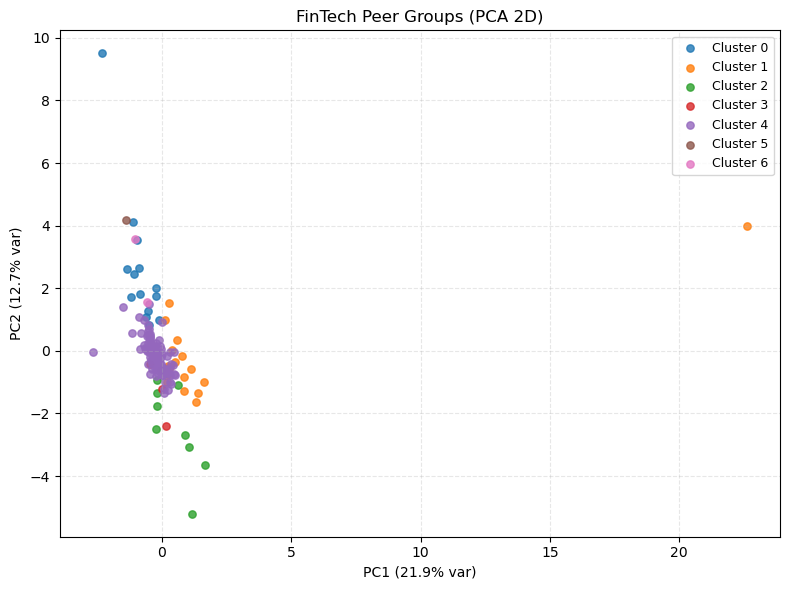

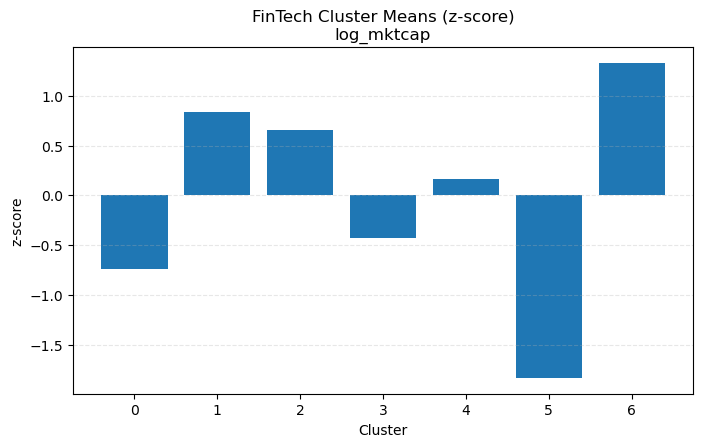

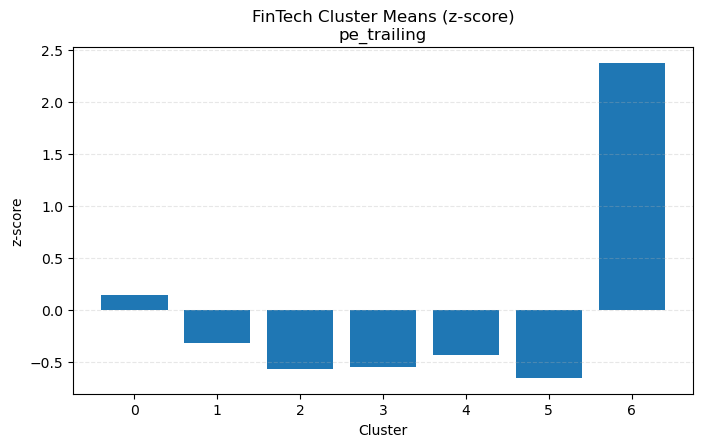

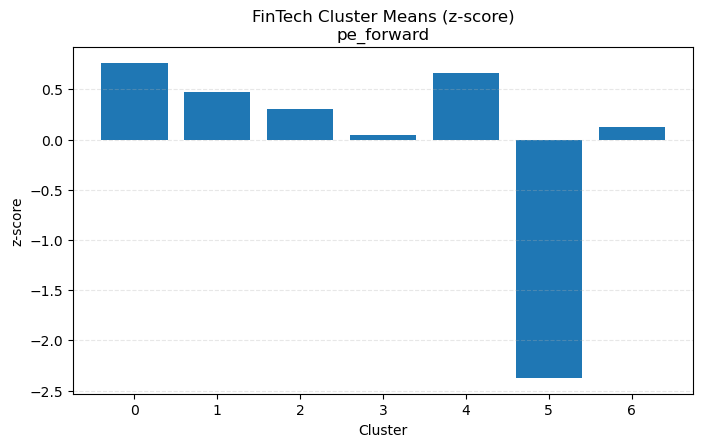

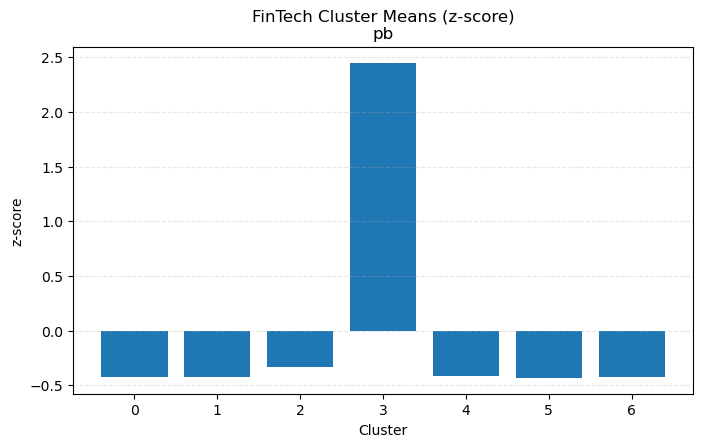

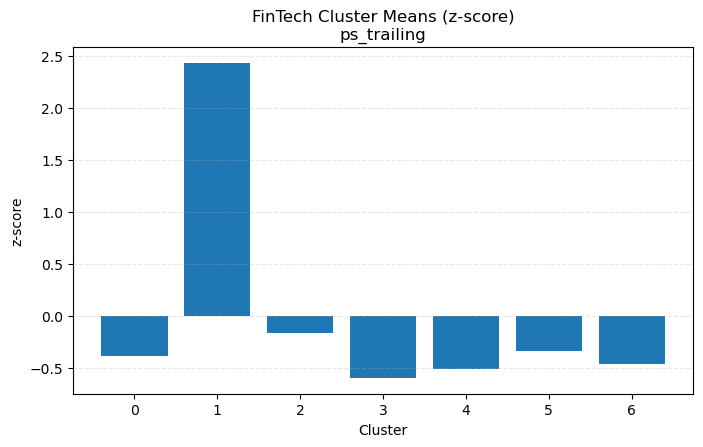

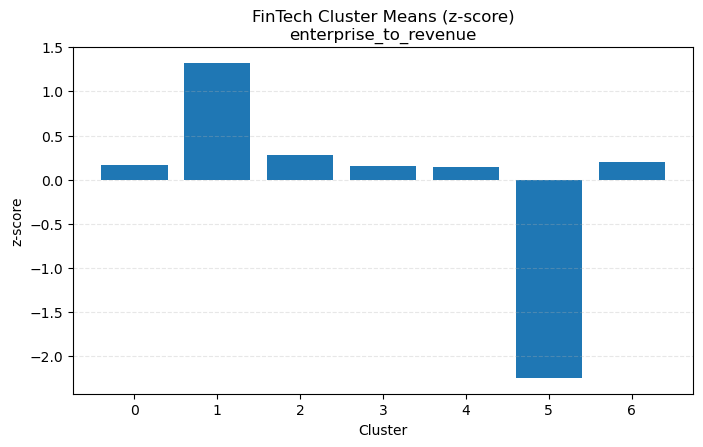

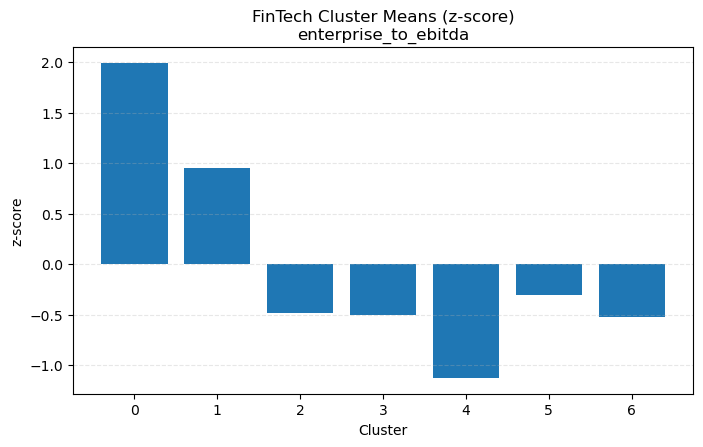

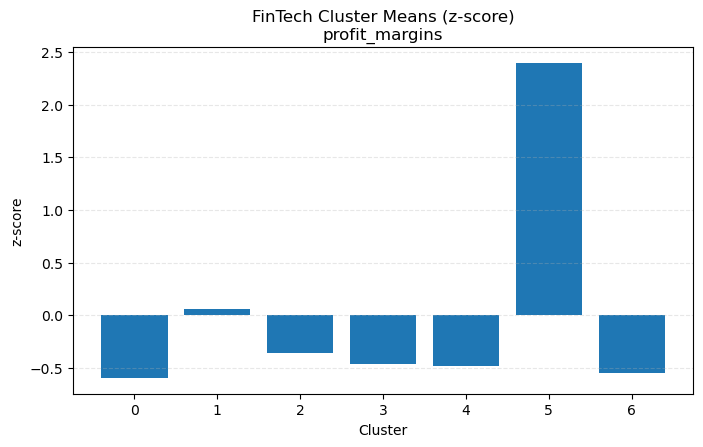

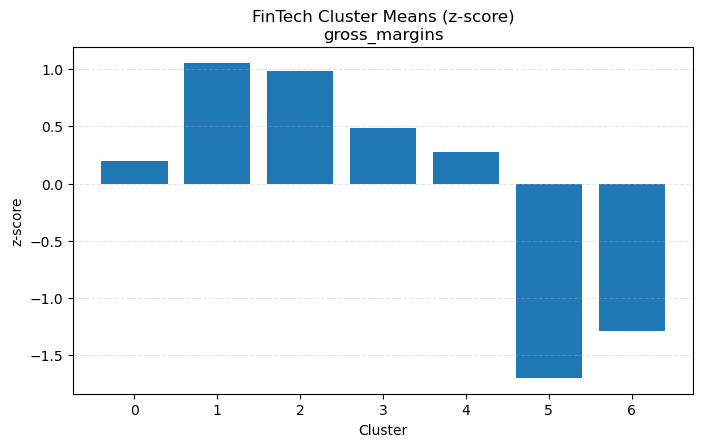

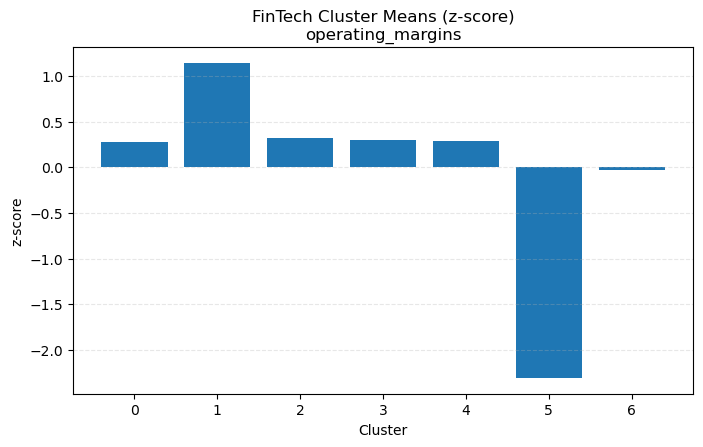

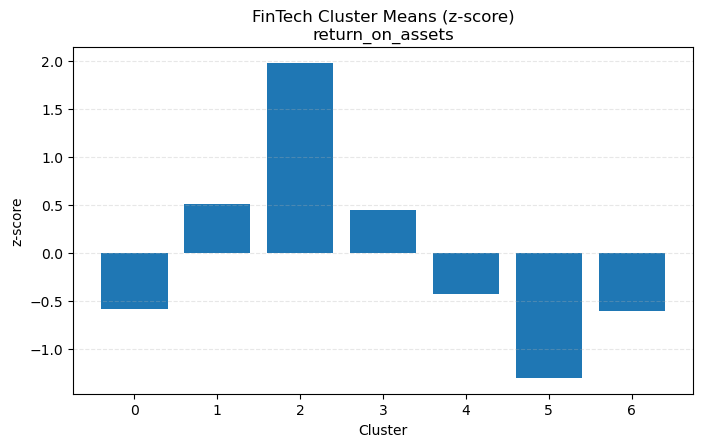

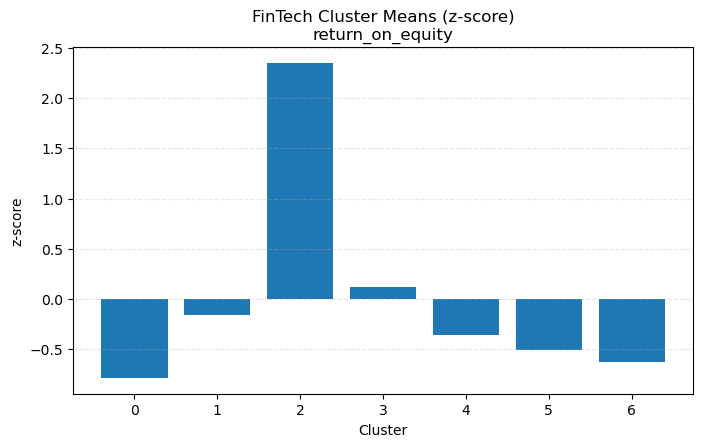

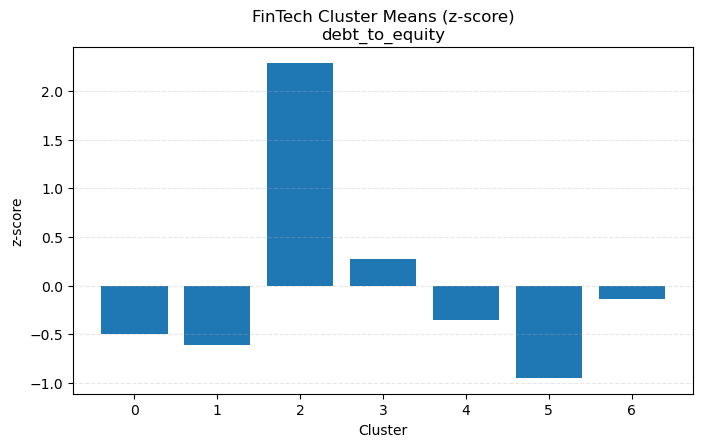

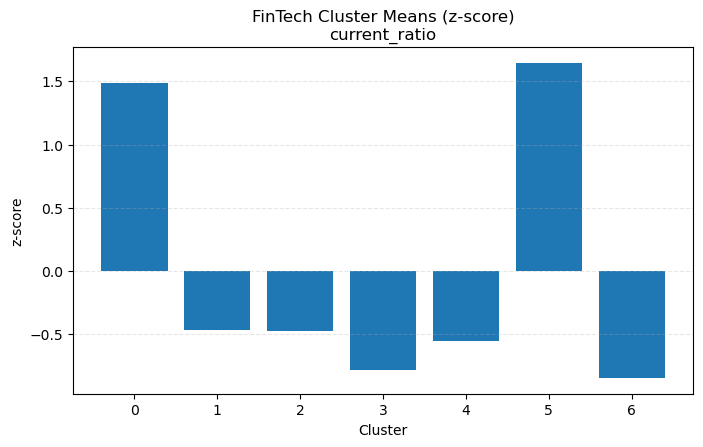

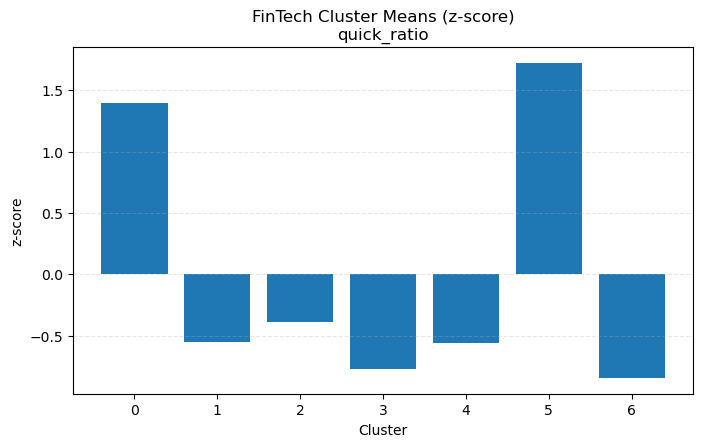

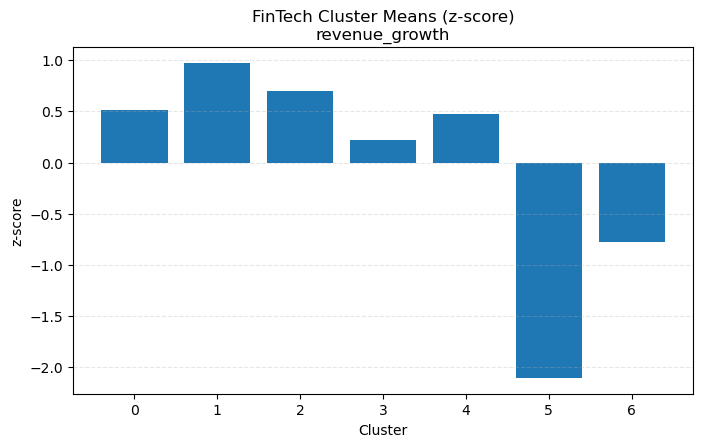

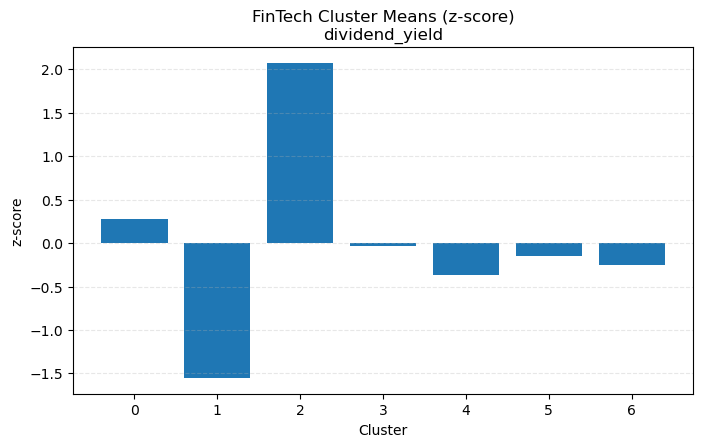

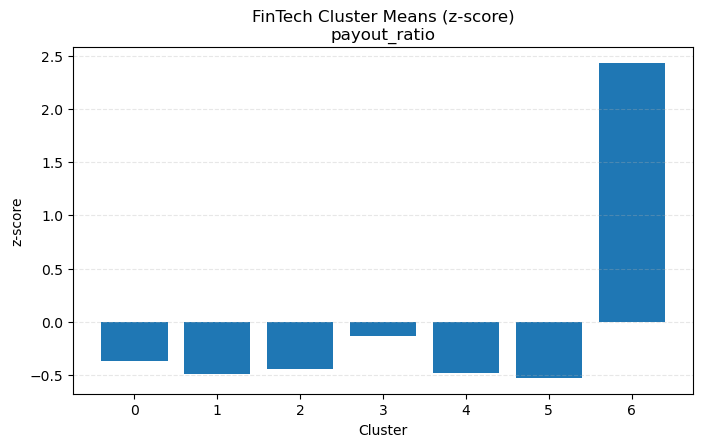

<Figure size 800x800 with 0 Axes>

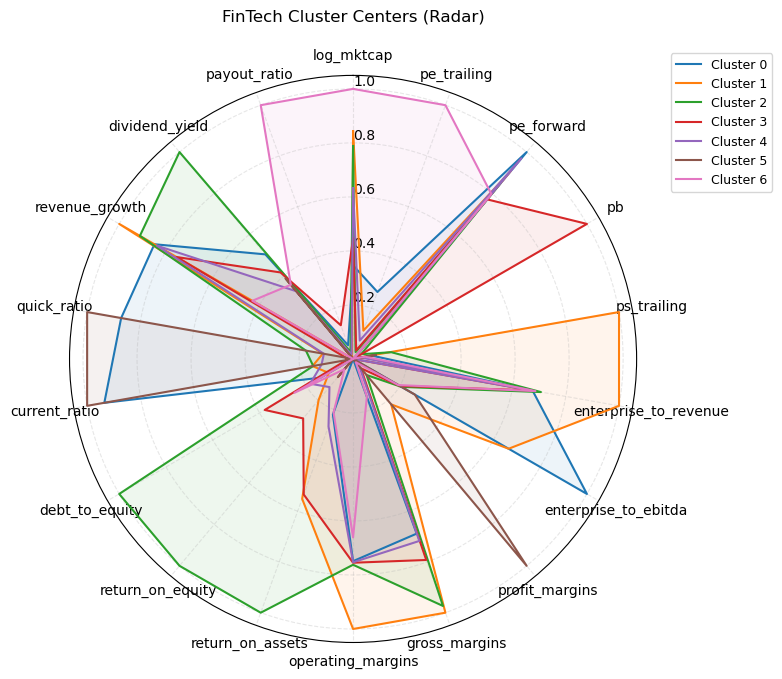

In [24]:
# 假设你已有：
# details: 每家公司明细 + Cluster 列
# summary: 各簇均值 + NamesInCluster 列
# used_feature_cols: 你聚类时实际用到的列（例如 result["used_feature_cols"]）
used_feature_cols = [
    "log_mktcap","pe_trailing","pe_forward","pb","ps_trailing",
    "enterprise_to_revenue","enterprise_to_ebitda",
    "profit_margins","gross_margins","operating_margins",
    "return_on_assets","return_on_equity",
    "debt_to_equity","current_ratio","quick_ratio",
    "revenue_growth","dividend_yield","payout_ratio"
]




# 1) 二维散点（PCA）
plot_clusters_scatter_2d(details, feature_cols=used_feature_cols, title="FinTech Peer Groups (PCA 2D)", savepath='details')

# 2) 每个特征的簇均值对比（z-score）
plot_cluster_means_bar(summary, feature_cols=used_feature_cols, title_prefix="FinTech Cluster Means (z-score)", save_dir=None)

# 3) 簇中心雷达图（列间归一化到[0,1]）
plot_cluster_centers_radar(summary, feature_cols=used_feature_cols, title="FinTech Cluster Centers (Radar)", savepath='Data')
